# Ciclo de Rankine 

Este ciclo termodinámico está constituido por:

1) Una turbina, de la cual se obtiene la potencia del sistema Wturb (y se convierte en energía eléctrica a través de un generador). Se realiza una expansión del fluido.

2) Un condensador para condensar el vapor a la salida de la turbina. Este extrae el calor Qout (pérdida isobárica de calor).

3) Una bomba que eleva la presión del fluido, consumiendo una potencia Wpump.

4) Una caldera que aporta calor Qin al fluido para calentarlo al estado previo al turbinado. Se realiza una absorción isobárica de calor.

### Pasos para resolver problemas:

1) Identificación de los estados:

    entalpía [kJ/kg], entropía [kJ/kgK], temperatura [K], presión [MPa], calidad/grado de vapor
    
2) Cálculo de potencias/calores:

    absolutos:
    W//Q = m/t * dh [kW]
    Wcycle = Qin - Qout = Wt - Wp = m/t * ((h1-h2)-(h4-h3)) [kW]
    
    específicos:
    w//q = dh [kJ/kg]
    
3) Cálculo de rendimientos:

    Rendimiento térmico: 
    eta = (Wturb-Wpump)/Qin
    
    Back work ratio: 
    bwr = Wpump/Wturb
    
    Rendimiento isoentrópico de la turbina (cociente entre trabajo real e ideal de la turbina):
    eta(turb) = Wturb(real)/Wturb(ideal)
    
    Rendimiento isoentrópico de la bomba (cociente entre trabajo ideal y real ejercido por la bomba):
    eta(pump) = Wpump(ideal)/Wpump(real)

## Librerías utilizadas

In [1]:
#pip install seuif97
#Instalamos seuif en el notebook, el cual nos permite definir completamente un estado a partir de 2 valores conocidos.
# Ej.: 
# x = pt2x() Calculamos grado de vapor a partir de presión y temperatura
# s = ph2s() Calculamos entropía a partir de presión y entalpía
import seuif97 as sf
from seuif97 import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Se crea una clase llamada State para definir los estados en todos los ejercicios (excepto en el primero)

In [2]:
class State(object): #todas las clases tienen la función init, se usa el double underscore para funciones ya asignadas
    def __init__(self, numero='',descripcion='', **kwargs): #key word arguments
        self.numero = numero
        self.descripcion = descripcion
        self.kwargs = kwargs
        self.all_keys = ('t','p','s','h','x') #todos los valores termodinámicos que se van a calcular
        for kwarg, val in kwargs.items():
            setattr(self, kwarg, val) #es lo mismo que hacer self.t = 480, es decir, se asignan los valores a los argumentos
        self.calcular_propiedades()
        #llamaremos a esta clase para definir complemtamento los estados en todos los ciclos, calculando todos los valores
        #termodinámicos en la función calcular_propiedades()
            
    def __repr__(self): #self hay que pasarlo siempre
        #En el caso de que queramos saber la información sobre uno o varios estados en concreto, podemos pedir 
        #que se imprima y aparecerá el estado con toda la información siguiente:
        return f'Estado {self.numero} - {self.descripcion}: P = {self.p:.4f} MPa, T = {self.t:.2f} ºC, '\
                f'x = {self.x:.2f} p.u., h = {self.h:.2f} kJ/kg, s = {self.s:.2f} kJ/kgK' #:.2f es para indicar 2 decimales

    
    def calcular_propiedades(self):
        keys = [k for k in self.kwargs.keys()] #los valores conocidos que introducimos
        #keys = list(self.kwargs.keys()) sería lo mismo
        unknown_keys = list(set(self.all_keys).difference(keys)) #los valores desconocidos son la diferencia entre todos y los conocidos
        function = ''.join(keys) #esto es para unir los input y formar el nombre de las funciones para calcular los demas valores
        #values = [v for v in self.kwargs.values()] ##los diccionarios no están ordenados
        values = [getattr(self, k) for k in keys]
        for var in unknown_keys:
            try:
                setattr(self, var, getattr(sf,f'{function}2{var}')(*values)) #f'' hace lo mismo que ''.format()
                #aplicamos el cálculo explicado previamente, puede ser que dé error porque seuif requiere escribir
                #la fórmula en un orden concreto, si este fuera el caso les damos la vuelta:
            except AttributeError as e:
                setattr(self, var, getattr(sf,f'{function[::-1]}2{var}')(*values[::-1]))

# 1) Ciclo Rankine ideal (Ciclo reversible)

### Este primer ejercicio se realizará paso a paso y de forma simple (sin usar clases), mientras que los demás ejercicios utilizarán clases para ser generalizados.
Se asume que tanto la turbina como la bomba son ideales (isentrópicas): eta_T = eta_P = 1

In [3]:
#Datos
p1 = 8 #[MPa]
p2 = 0.008
x1 = 1 #vapor saturado
Wcycle = 100*1000 #[kW]

In [4]:
#Primer estado: antes de la turbina y después de la caldera
t1 = px2t(p1, x1)
h1 = px2h(p1, x1)        
s1 = px2s(p1, x1)

In [5]:
#Segundo estado: después de la turbina y antes del condensador
s2 = s1 #ciclo reversible -> isoentrópico
t2 = ps2t(p2, s2)
h2 = ps2h(p2, s2)        
x2 = ps2x(p2, s2) #vapor húmedo

In [6]:
#Tercer estado: después del condensador y antes de la bomba
t3 = t2 #condensación isotérmica e isobárica a líquido saturado
p3 = p2
x3 = 0
s3 = tx2s(t3, x3)
h3 = tx2h(t3, x3)        

In [7]:
#Cuarto estado: después de la bomba y antes de la caldera
s4 = s3 #ciclo reversible -> isoentrópico
p4 = p1 #absorción isobárica de calor en la caldera por parte del fluido
x4 = 0 #agua líquida
h4 = ps2h(p4, s4)
t4 = ps2t(p4, s4)

In [8]:
#Mostramos todos los valores de los estados en un pandas dataframe
estados = {'Presión [MPa]':[p1,p2,p3,p4],'Temperatura [ºC]':[t1,t2,t3,t4],'Entalpía [kJ/kg]':[h1,h2,h3,h4],'Entropía [kJ/kgK]':[s1,s2,s3,s4],'Calidad':[x1,x2,x3,x4]}
df = pd.DataFrame(estados)
df.index = ['Estado 1','Estado 2 reversible','Estado 3','Estado 4 reversible']
print('Apartado A)\n')
df

Apartado A)



,Presión [MPa],Temperatura [ºC],Entalpía [kJ/kg],Entropía [kJ/kgK],Calidad
Estado 1,8.000,295.009121,2758.611081,5.744849,1.000000
Estado 2 reversible,0.008,41.510053,1795.077037,5.744849,0.674839
Estado 3,0.008,41.510053,173.851769,0.592532,0.000000
Estado 4 reversible,8.000,41.751969,181.897786,0.592532,0.000000


In [9]:
#Rendimientos
#Para ello hay que calcular las potencias y los calores específicos
w_turb = h1-h2
w_pump = h4-h3
q_in = h1-h4

eta = (w_turb-w_pump)/q_in
bwr = w_pump/w_turb
print('Apartados B) y C)\n El rendimiento térmico es: {} \n y el back work ratio es: {}'.format(eta,bwr))

Apartados B) y C)
 El rendimiento térmico es: 0.3708165857431649 
 y el back work ratio es: 0.008350527644018554


In [10]:
# Flujo de masa
mflow = Wcycle/((h1-h2)-(h4-h3)) #kg/s
print('Apartado D)\n El flujo de masa es: {} kg/s.'.format(mflow))

Apartado D)
 El flujo de masa es: 104.65855902980353 kg/s.


In [11]:
# Potencias y calores absolutos
Wturb = mflow*(h1-h2)
Qout = mflow*(h2-h3)
Wpump = mflow*(h4-h3)
Qin = mflow*(h1-h4)
print('Apartados E) y F)\n El trabajo de la turbina es {} kW,\n el de la bomba es {} kW,\n el calor introducido por la caldera es {} kW \n y el extraído por el condensador es {} kW.'.format(Wturb,Wpump,Qin,Qout))

Apartados E) y F)
 El trabajo de la turbina es 100842.0846152602 kW,
 el de la bomba es 842.0846152601885 kW,
 el calor introducido por la caldera es 269675.10042623075 kW 
 y el extraído por el condensador es 169675.10042623078 kW.


Apartado G)



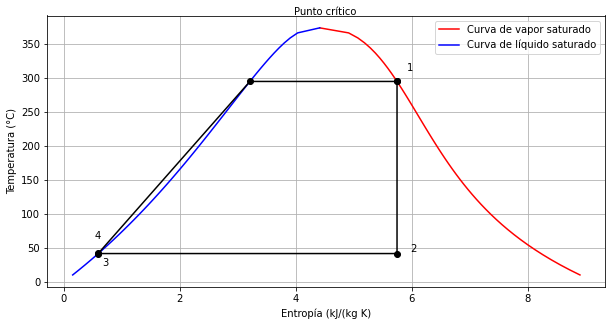

In [12]:
#Dibujo del ciclo de vapor
Tc = 647.096 - 273.15 #Temperatura del punto crítico [ºC]
print('Apartado G)\n')
plt.figure(figsize=(10.0,5.0))

# Líneas de líquido y vapor saturado 
npt = np.linspace(10,Tc) # rango de temperaturas
svap = [s for s in [tx2s(t, 1) for t in npt]]
sliq = [s for s in [tx2s(t, 0) for t in npt]]
#calculamos todas las temperaturas y entropías pertenecientes a líquido y vapor saturado para definir las líneas
plt.plot(svap, npt, 'r-')
plt.plot(sliq, npt, 'b-')
plt.legend(['Curva de vapor saturado','Curva de líquido saturado'])

#Pintamos el ciclo:
t=[t1,t2,t3,t4]
s=[s1,s2,s3,s4]

# Es necesario añadir el punto de líquido saturado a p1 para definir la curva
t.append(px2t(p1,0))
s.append(px2s(p1,0))

# Y finalizamos la curva de nuevo en el punto 1 de partida
t.append(t1)
s.append(s1)

plt.plot(s, t, 'ko-')
plt.xlabel('Entropía (kJ/(kg K)')
plt.ylabel('Temperatura (°C)')
#Anotamos los números indicativos de los estados en lugares adecuados en el gráfico
plt.annotate('1',xy=[s1*1.03,t1*1.05])
plt.annotate('2',xy=[s2*1.04,t2*1.05])
plt.annotate('3',xy=[s3*1.13,t3*0.55])
plt.annotate('4',xy=[s4*0.9,t4*1.5])
plt.annotate('Punto crítico',xy=[(tx2s(Tc, 1))*0.9,(Tc)*1.05])
plt.grid()

# 2) Ciclo de Rankine con irreversibilidades (ciclo real)

### A partir de este ejercicio se utilizará la clase State
El trabajo en la turbina y en la bomba es irreversible, por lo que se produce un aumento de entropía.

In [13]:
#Datos
p1 = 8 #[MPa]
p2 = 0.008
x1 = 1 #vapor saturado en la entrada de la turbina
x3 = 0 #líquido saturado en la entrada de la bomba
w_cycle = 100*1000 #[kW]
eta_T = 0.85 #Rendimiento isoentrópico de la turbina
eta_P = 0.85 #Rendimiento isoentrópico de la bomba

class RankineCycle(object):
    def __init__(self, p1, x1, p2, x3, w_cycle, eta_T, eta_P): #inicializamos la clase con todos los valores que toma y hacemos que siempre realice todos los cálculos
        self.p1 = p1
        self.x1 = x1
        self.p2 = p2
        self.x3 = x3
        self.w_cycle = w_cycle
        self.eta_T1 = eta_T
        self.eta_P = eta_P
        self.calcular_todo()
        
    def fijar_estados(self):
        #Definimos todos los estados gracias a la clase State
        self.estado1=State(1, 'Entrada turbina', x=self.x1, p=self.p1)
        self.estado2ideal=State('2i', 'Salida turbina (ideal)', s=self.estado1.s, p=self.p2)
        self.h2r = self.estado1.h-self.eta_T1*(self.estado1.h-self.estado2ideal.h) 
        #utilizamos los rendimientos para calcular los estados reales a partir de los ideales
        self.estado2=State(2, 'Salida turbina (real)', h=self.h2r, p=self.p2)
        self.estado3=State(3, 'Entrada bomba', x=self.x3, t=self.estado2.t)
        self.estado4ideal=State('4i', 'Salida bomba (ideal)', p=self.p1, s=self.estado3.s)
        self.h4r=(self.estado4ideal.h-self.estado3.h)/self.eta_P+self.estado3.h
        self.estado4=State(4, 'Salida bomba (real)', h=self.h4r, p=self.p1)
        self.states_order = [self.estado1, self.estado2, self.estado3, self.estado4]
        #Necesitamos solo los estados reales a la hora de pintar el ciclo
        self.all_states = [self.estado1, self.estado2ideal, self.estado2, self.estado3, self.estado4ideal, self.estado4]
        #Necesitamos todos los puntos (ideales y reales) a la hora de mostrar todos los estados y resultados
    
    #Se utilizan las mismas fórmulas utilizadas en el primer ejercicio, pero ordenadas dentro de la clase del ciclo
    def calcular_entalpias(self):
        self.w_T = self.estado1.h - self.estado2.h
        self.w_P = self.estado4.h - self.estado3.h
        self.q_in = self.estado1.h - self.estado4.h
        self.q_out = self.estado2.h - self.estado3.h
        
    def calcular_rendimientos(self):
        self.eta_th = (self.w_T_kw - self.w_P_kw)/self.q_in_kw
        self.bwr = self.w_P_kw/(self.w_T_kw)
        
    def calcular_flujo_masico(self):
        self.mass_flow = (self.w_cycle)/(self.w_T - self.w_P)
            
    def calcular_potencias(self):
        self.w_T_kw = self.w_T * self.mass_flow
        self.w_P_kw = self.w_P * self.mass_flow
        self.q_in_kw = self.q_in * self.mass_flow
        self.q_out_kw = self.q_out * self.mass_flow
        
    def calcular_todo(self):
        self.fijar_estados()
        self.calcular_entalpias()
        self.calcular_flujo_masico()
        self.calcular_potencias()
        self.calcular_rendimientos()
        
    def hacer_df(self):
        #Nos permite imprimir un pandas dataframe para imprimir los resultados de una forma más atractiva que solicitando cada estado
        estadosr = {'Presión [MPa]':[self.all_states[k].p for k in range(len(self.all_states))],
                    'Temperatura [ºC]':[self.all_states[k].t for k in range(len(self.all_states))],
                    'Entalpía [kJ/kg]':[self.all_states[k].h for k in range(len(self.all_states))],
                    'Entropía [kJ/kgK]':[self.all_states[k].s for k in range(len(self.all_states))],
                    'Calidad':[self.all_states[k].x for k in range(len(self.all_states))]}
        df = pd.DataFrame(estadosr)
        df.index = ['Estado 1', 'Estado 2 reversible', 'Estado 2 irreversible','Estado 3','Estado 4 reversible', 'Estado 4 irreversible']
        print('Apartado A)\n')
        return df
            
    def mostrar_resultados(self):
        print(f'Apartado B)\n El rendimiento térmico es: eta = {self.eta_th:.3f}.')
        print(f'Apartado C)\n El back work ratio es: bwr = {self.bwr:.3f}.')
        print(f'Apartado D)\n El flujo de masa es: m_dot = {self.mass_flow:.3f} kg/s.')
#         print(
#             f'El calor introducido por la caldera es Qin = {self.q_in:.2f} KJ/kg, Qout = {self.q_out:.2f}  KJ/kg, Wt1 = {self.w_t1:.2f} KJ/kg, '
#             f'Wt2 = {self.w_t2:.2f} KJ/kg, Wp = {self.w_p:.2f} KJ/kg')
        print(f'Apartado E)\n El calor introducido por la caldera es: Qin = {self.q_in_kw:.2f} kW,\n el extraído por el condensador es: Qout = {self.q_out_kw:.2f} kW.')
        print(f'Apartado F)\n El trabajo de la turbina es Wt = {self.w_T_kw:.2f} kW,\n y el trabajo de la bomba es: Wp = {self.w_P_kw:.2f} kW.')
        
    def pintar_ciclo(self):
        print('Apartado G)\n')
        Tc = 647.096 - 273.15 #Temperatura del punto crítico [ºC]
        plt.figure(figsize=(10.0,5.0))
        # Líneas de líquido y vapor saturado 
        npt = np.linspace(10,Tc,200)
        svap = [s for s in [tx2s(t, 1) for t in npt]]
        sliq = [s for s in [tx2s(t, 0) for t in npt]]
        plt.plot(svap, npt, 'r-')
        plt.plot(sliq, npt, 'b-')
        plt.legend(['Curva de vapor saturado','Curva de líquido saturado'])

        t=[self.states_order[k].t for k in range(len(self.states_order))]
        s=[self.states_order[k].s for k in range(len(self.states_order))]
        #Agrupamos todos los valores de temperatura y entropía de los puntos del ciclo real

        # Es necesario añadir el punto de líquido saturado a p1 para definir la curva
        self.estado_a = State('a', p=self.estado1.p, x=0)
        t.append(self.estado_a.t)
        s.append(self.estado_a.s)

        # Y finalizamos la curva de nuevo en el punto 1 de partida
        t.append(self.estado1.t)
        s.append(self.estado1.s)

        plt.plot(s, t, 'ko-')

        #Marcamos el recorrido del turbinado ideal
        tTi=[self.estado1.t,self.estado2ideal.t]
        sTi=[self.estado1.s,self.estado2ideal.s]
        plt.plot(sTi, tTi, 'ko--')

        #Marcamos el recorrido del bombeado ideal
        tPi=[self.estado3.t,self.estado4ideal.t]
        sPi=[self.estado3.s,self.estado4ideal.s]
        plt.plot(sPi, tPi, 'ko--')

        plt.xlabel('Entropía (kJ/(kg K)')
        plt.ylabel('Temperatura (°C)')
        plt.annotate('1',xy=[self.estado1.s*1.03,self.estado1.t*1.05])
        plt.annotate('2 real',xy=[self.estado2.s*1.04,self.estado2.t*1.05])
        plt.annotate('2 ideal',xy=[self.estado2ideal.s*0.88,self.estado2ideal.t*1.3])
        plt.annotate('3',xy=[self.estado3.s*1.13,self.estado3.t*0.55])
        plt.annotate('4 ideal\n y real',xy=[self.estado4.s*0.1,self.estado4.t*1.5])
        plt.annotate('Punto crítico',xy=[(tx2s(Tc, 1))*0.9,(Tc)*1.05])
        plt.grid()

In [14]:
ciclo = RankineCycle(p1, x1, p2, x3, w_cycle, eta_T, eta_P)
df = ciclo.hacer_df()
df

Apartado A)



,Presión [MPa],Temperatura [ºC],Entalpía [kJ/kg],Entropía [kJ/kgK],Calidad
Estado 1,8.000,295.009121,2758.611081,5.744849,1.000000
Estado 2 reversible,0.008,41.510053,1795.077037,5.744849,0.674839
Estado 2 irreversible,0.008,41.510053,1939.607143,6.204171,0.735000
Estado 3,0.008,41.510053,173.851769,0.592532,0.000000
Estado 4 reversible,8.000,41.751969,181.897786,0.592532,0.000000
Estado 4 irreversible,8.000,42.093301,183.317672,0.597038,0.000000


Apartado B)
 El rendimiento térmico es: eta = 0.314.
Apartado C)
 El back work ratio es: bwr = 0.012.
Apartado D)
 El flujo de masa es: m_dot = 123.527 kg/s.
Apartado E)
 El calor introducido por la caldera es: Qin = 318118.89 kW,
 el extraído por el condensador es: Qout = 218118.89 kW.
Apartado F)
 El trabajo de la turbina es Wt = 101169.30 kW,
 y el trabajo de la bomba es: Wp = 1169.30 kW.
Apartado G)



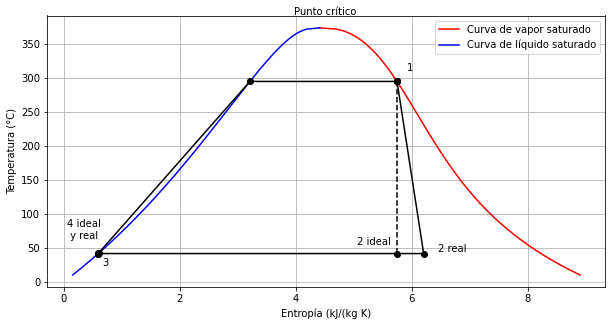

In [15]:
ciclo.mostrar_resultados()
ciclo.pintar_ciclo()

# 3) Ciclo de Rankine con sobrecalentamiento

Después de la caldera, el fluido pasa por un sobrecalentador para pasar de vapor saturado a vapor sobrecalentado (T1s = 450ºC). Esto permite que, al pasar por la turbina y llegar al estado 2, el grado de vapor sea mayor y así se reduzca el desgaste de la turbina por el movimiento de pequeñas gotas de agua a muy altas velocidades.

In [16]:
#Datos
p1 = 8 #[MPa]
t1 = 450 #[ºC]
p2 = 0.008
x3 = 0 #líquido saturado en la entrada de la bomba
w_cycle = 100*1000 #[kW]
eta_T = 0.85 #Rendimiento isoentrópico de la turbina
eta_P = 0.85 #Rendimiento isoentrópico de la bomba

class RankineCycleOverheat(object):
    #Utilizamos prácticamente la misma clase que en el ejercicio anterior, pero la adaptamos al nuevo ciclo
    def __init__(self, p1, t1, p2, x3, w_cycle, eta_T, eta_P):
        self.p1 = p1
        self.t1 = t1
        self.p2 = p2
        self.x3 = x3
        self.w_cycle = w_cycle
        self.eta_T1 = eta_T
        self.eta_P = eta_P
        self.calcular_todo()
        
    def fijar_estados(self):
        self.estado1=State(1, 'Entrada turbina', t=self.t1, p=self.p1)
        self.estado2ideal=State('2i', 'Salida turbina (ideal)', s=self.estado1.s, p=self.p2)
        self.h2r = self.estado1.h-self.eta_T1*(self.estado1.h-self.estado2ideal.h)
        self.estado2=State(2, 'Salida turbina (real)', h=self.h2r, p=self.p2)
        self.estado3=State(3, 'Entrada bomba', x=self.x3, t=self.estado2.t)
        self.estado4ideal=State('4i', 'Salida bomba (ideal)', p=self.p1, s=self.estado3.s)
        self.h4r=(self.estado4ideal.h-self.estado3.h)/self.eta_P+self.estado3.h
        self.estado4=State(4, 'Salida bomba (real)', h=self.h4r, p=self.p1)
        self.states_order = [self.estado1, self.estado2, self.estado3, self.estado4]
        self.all_states = [self.estado1, self.estado2ideal, self.estado2, self.estado3, self.estado4ideal, self.estado4]
        
    def calcular_entalpias(self):
        self.w_T = self.estado1.h - self.estado2.h
        self.w_P = self.estado4.h - self.estado3.h
        self.q_in = self.estado1.h - self.estado4.h
        self.q_out = self.estado2.h - self.estado3.h
        
    def calcular_rendimientos(self):
        self.eta_th = (self.w_T_kw - self.w_P_kw)/self.q_in_kw
        self.bwr = self.w_P_kw/(self.w_T_kw)
        
    def calcular_flujo_masico(self):
        self.mass_flow = (self.w_cycle)/(self.w_T - self.w_P)
            
    def calcular_potencias(self):
        self.w_T_kw = self.w_T * self.mass_flow
        self.w_P_kw = self.w_P * self.mass_flow
        self.q_in_kw = self.q_in * self.mass_flow
        self.q_out_kw = self.q_out * self.mass_flow
        
    def calcular_todo(self):
        self.fijar_estados()
        self.calcular_entalpias()
        self.calcular_flujo_masico()
        self.calcular_potencias()
        self.calcular_rendimientos()
        
    def hacer_df(self):
        estadosr = {'Presión [MPa]':[self.all_states[k].p for k in range(len(self.all_states))],
                    'Temperatura [ºC]':[self.all_states[k].t for k in range(len(self.all_states))],
                    'Entalpía [kJ/kg]':[self.all_states[k].h for k in range(len(self.all_states))],
                    'Entropía [kJ/kgK]':[self.all_states[k].s for k in range(len(self.all_states))],
                    'Calidad':[self.all_states[k].x for k in range(len(self.all_states))]}
        df = pd.DataFrame(estadosr)
        df.index = ['Estado 1', 'Estado 2 reversible', 'Estado 2 irreversible','Estado 3','Estado 4 reversible', 'Estado 4 irreversible']
        print('Apartado A)\n')
        return df
            
    def mostrar_resultados(self):
        print(f'Apartado B)\n El rendimiento térmico es: eta = {self.eta_th:.3f}.')
        print(f'Apartado C)\n El back work ratio es: bwr = {self.bwr:.3f}.')
        print(f'Apartado D)\n El flujo de masa es: m_dot = {self.mass_flow:.3f} kg/s.')
#         print(
#             f'El calor introducido por la caldera es Qin = {self.q_in:.2f} KJ/kg, Qout = {self.q_out:.2f}  KJ/kg, Wt1 = {self.w_t1:.2f} KJ/kg, '
#             f'Wt2 = {self.w_t2:.2f} KJ/kg, Wp = {self.w_p:.2f} KJ/kg')
        print(f'Apartado E)\n El calor introducido por la caldera es: Qin = {self.q_in_kw:.2f} kW,\n el extraído por el condensador es: Qout = {self.q_out_kw:.2f} kW.')
        print(f'Apartado F)\n El trabajo de la turbina es Wt = {self.w_T_kw:.2f} kW,\n y el trabajo de la bomba es: Wp = {self.w_P_kw:.2f} kW.')
        
    def pintar_ciclo(self):
        print('Apartado G)\n')
        Tc = 647.096 - 273.15 #Temperatura del punto crítico [ºC]
        plt.figure(figsize=(10.0,5.0))
        # Líneas de líquido y vapor saturado 
        npt = np.linspace(10,Tc,200) # range of temperatures
        svap = [s for s in [tx2s(t, 1) for t in npt]]
        sliq = [s for s in [tx2s(t, 0) for t in npt]]
        plt.plot(svap, npt, 'r-')
        plt.plot(sliq, npt, 'b-')
        plt.legend(['Curva de vapor saturado','Curva de líquido saturado'])

        t=[self.states_order[k].t for k in range(len(self.states_order))]
        s=[self.states_order[k].s for k in range(len(self.states_order))]

        # Es necesario añadir los puntos de líquido y vapor saturado a p1 para definir la curva, y finalmente el punto 1 de partida
        self.estado_a = State('a', p=self.estado1.p, x=0)
        self.estado_b = State('b', p=self.estado1.p, x=1)
        t.append(self.estado_a.t)
        t.append(self.estado_b.t)
        t.append(self.estado1.t)
        s.append(self.estado_a.s)
        s.append(self.estado_b.s)
        s.append(self.estado1.s)

        plt.plot(s, t, 'ko-')

        #Marcamos el recorrido del turbinado ideal
        tTi=[self.estado1.t,self.estado2ideal.t]
        sTi=[self.estado1.s,self.estado2ideal.s]
        plt.plot(sTi, tTi, 'ko--')

        #Marcamos el recorrido del bombeado ideal
        tPi=[self.estado3.t,self.estado4ideal.t]
        sPi=[self.estado3.s,self.estado4ideal.s]
        plt.plot(sPi, tPi, 'ko--')
        
        plt.xlabel('Entropía (kJ/(kg K)')
        plt.ylabel('Temperatura (°C)')
        plt.annotate('1 sin sobre-\n calentador',xy=[self.estado_b.s*0.84,self.estado_b.t*0.85])
        plt.annotate('1 con\n sobrecalentador',xy=[self.estado1.s*1.05,self.estado1.t*0.93])
        plt.annotate('2 real',xy=[self.estado2.s*1.02,self.estado2.t*1.05])
        plt.annotate('2 ideal',xy=[self.estado2ideal.s*0.88,self.estado2ideal.t*1.3])
        plt.annotate('3',xy=[self.estado3.s*1.13,self.estado3.t*0.5])
        plt.annotate('4 ideal\n y real',xy=[self.estado4.s*0.1,self.estado4.t*1.5])
        plt.annotate('Punto crítico',xy=[(tx2s(Tc, 1))*0.9,(Tc)*1.05])
        plt.grid()

In [17]:
ciclo = RankineCycleOverheat(p1, t1, p2, x3, w_cycle, eta_T, eta_P)
df = ciclo.hacer_df()
df

Apartado A)



,Presión [MPa],Temperatura [ºC],Entalpía [kJ/kg],Entropía [kJ/kgK],Calidad
Estado 1,8.000,450.000000,3273.234029,6.557677,1.000000
Estado 2 reversible,0.008,41.510053,2050.841024,6.557677,0.781302
Estado 2 irreversible,0.008,41.510053,2234.199974,7.140399,0.857625
Estado 3,0.008,41.510053,173.851769,0.592532,0.000000
Estado 4 reversible,8.000,41.751969,181.897786,0.592532,0.000000
Estado 4 irreversible,8.000,42.093301,183.317672,0.597038,0.000000


Apartado B)
 El rendimiento térmico es: eta = 0.333.
Apartado C)
 El back work ratio es: bwr = 0.009.
Apartado D)
 El flujo de masa es: m_dot = 97.128 kg/s.
Apartado E)
 El calor introducido por la caldera es: Qin = 300117.71 kW,
 el extraído por el condensador es: Qout = 200117.71 kW.
Apartado F)
 El trabajo de la turbina es Wt = 100919.41 kW,
 y el trabajo de la bomba es: Wp = 919.41 kW.
Apartado G)



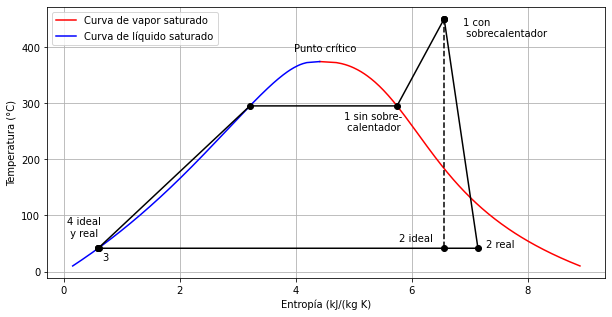

In [18]:
ciclo.mostrar_resultados()
ciclo.pintar_ciclo()

# 4) Ciclo de Rankine con recalentamiento
### Tras pasar el fluido por una primera turbina, es llevado de nuevo a la caldera para recalentarlo y hacerlo pasar por una segunda turbina, mejorando de esta manera el rendimiento del ciclo por un mejor aprovechamiento del calor empleado.
Un ciclo de Rankine con recalentamiento, con irreversibilidades en la turbina y en la bomba, trabaja
con vapor de agua. El vapor entra a la primera etapa de la turbina a una temperatura de 500 ºC y a
una presión de 10 MPa, y se expande hasta los 0.8 MPa. Luego, el vapor es recalentado hasta una
temperatura de 460ºC. Tras pasar la segunda etapa de la turbina, el vapor entra al condensador a una
presión de 0.008 MPa, y sale hacia la bomba como líquido saturado. El trabajo neto del ciclo es de
200 MW. Los rendimientos de ambas etapas de la turbina (ηt1 y ηt2) son 0.91 y 0.93 respectivamente;
y el de la bomba (ηp) es 0.88.

In [19]:
t1 = 500 #[ºC]
p1 = 10 #[MPa]
p2 = 0.8
t3 = 460
p4 = 0.008
x5 = 0
w_cycle = 200*1000 #[kW]
eta_T1 = 0.91 #Primera turbina, antes del recalentamiento
eta_T2 = 0.93 #Segunda turbina, después del recalentamiento
eta_P = 0.88
# Para el apartado D)
Tin = 15 #[ºC]
Tout = 35

class RankineCycleReheat(object):
    #Utilizamos prácticamente la misma clase que en el ejercicio anterior, pero la adaptamos al nuevo ciclo
    def __init__(self, p1, t1, p2, t3, p4, x5, w_cycle, eta_T1, eta_T2, eta_P, Tin, Tout):
        self.t1 = t1
        self.p1 = p1
        self.p2 = p2
        self.t3 = t3
        self.p4 = p4
        self.x5 = x5
        self.w_cycle = w_cycle
        self.eta_T1 = eta_T1
        self.eta_T2 = eta_T2
        self.eta_P = eta_P
        self.Tin = Tin
        self.Tout = Tout
        self.calcular_todo()
        
    def fijar_estados(self):
        self.estado1=State(1, 'Entrada turbina', t=self.t1, p=self.p1)
        self.estado2ideal=State('2i', 'Salida turbina etapa 1 (ideal)', s=self.estado1.s, p=self.p2)
        self.h2r = self.estado1.h-self.eta_T1*(self.estado1.h-self.estado2ideal.h)
        self.estado2=State(2, 'Salida turbina etapa 1 (real)', h=self.h2r, p=self.p2)
        self.estado3=State(3, 'Entrada turbina etapa 2', p=self.estado2.p, t=self.t3)
        self.estado4ideal=State('4i', 'Salida turbina etapa 2 (ideal)', s=self.estado3.s, p=self.p4)
        self.h4r=self.estado3.h - self.eta_T2*(self.estado3.h-self.estado4ideal.h)
        self.estado4=State(4, 'Salida turbina etapa 2 (real)', h=self.h4r, p=self.p4)
        self.estado5=State(5, 'Entrada bomba', x=self.x5, p=self.estado4.p)
        self.estado6ideal=State('6i', 'Salida bomba (ideal)', p=self.p1, s=self.estado5.s)
        self.h6r=(self.estado6ideal.h-self.estado5.h)/self.eta_P+self.estado5.h
        self.estado6=State(6, 'Salida bomba (real)', h=self.h6r, p=self.p1)
        self.states_order = [self.estado1, self.estado2, self.estado3, self.estado4, self.estado5, self.estado6]
        self.all_states = [self.estado1, self.estado2ideal, self.estado2, self.estado3, self.estado4ideal, self.estado4,
                             self.estado5, self.estado6ideal, self.estado6]
        
    def calcular_entalpias(self):
        self.w_T1 = self.estado1.h - self.estado2.h
        self.w_T2 = self.estado3.h - self.estado4.h
        self.w_P = self.estado6.h - self.estado5.h
        #En este ciclo hay dos aportes de calor (recalentamiento tras primer turbinado)
        self.q_in_caldera = self.estado1.h - self.estado6.h
        self.q_in_recalentamiento = self.estado3.h - self.estado2.h
        self.q_in = self.q_in_caldera + self.q_in_recalentamiento
        self.q_out = self.estado4.h - self.estado5.h
        
    def calcular_rendimientos(self):
        self.eta_th = (self.w_T1 + self.w_T2 - self.w_P)/self.q_in #hay que tener en cuenta el trabajo de ambas turbinas
        self.bwr = self.w_P/(self.w_T1 + self.w_T2)
        
    def calcular_flujo_masico(self):
        self.mass_flow = (self.w_cycle)/(self.w_T1 + self.w_T2 - self.w_P)
            
    def calcular_potencias(self):
        self.w_T1_kw = self.w_T1 * self.mass_flow
        self.w_T2_kw = self.w_T2 * self.mass_flow
        self.w_P_kw = self.w_P * self.mass_flow
        self.q_in_kw = self.q_in * self.mass_flow
        self.q_out_kw = self.q_out * self.mass_flow
        
    def calcular_flujo_refrigerante(self):
        #En el apartado D) se pide calcular el flujo másico del agua de refrigeración en el condensador a partir 
        #de su diferencia de temperaturas a la entrada y a la salida       
        c_p = 4.184 #calor específico del agua (líquido refrigerante)[kJ/kgK]
        #El calor absorbido por el agua del condensador provocará una diferencia de entalpías a la entrada y a la
        #salida, también representable en una diferencia de temperaturas:
        #Qin_cond = Qout (del ciclo) = m_aguaflow * (hout - hin) = m_aguaflow * c_p * (Tout - Tin)
        self.agua_massflow = self.q_out_kw/(c_p * (self.Tout - self.Tin))
        
    def calcular_todo(self):
        self.fijar_estados()
        self.calcular_entalpias()
        self.calcular_flujo_masico()
        self.calcular_potencias()
        self.calcular_rendimientos()
        self.calcular_flujo_refrigerante()
    
    def hacer_df(self):
        estadosr = {'Presión [MPa]':[self.all_states[k].p for k in range(len(self.all_states))],
                    'Temperatura [ºC]':[self.all_states[k].t for k in range(len(self.all_states))],
                    'Entalpía [kJ/kg]':[self.all_states[k].h for k in range(len(self.all_states))],
                    'Entropía [kJ/kgK]':[self.all_states[k].s for k in range(len(self.all_states))],
                    'Calidad':[self.all_states[k].x for k in range(len(self.all_states))]}
        df = pd.DataFrame(estadosr)
        df.index = ['Estado 1', 'Estado 2 reversible', 'Estado 2 irreversible','Estado 3','Estado 4 reversible', 
                    'Estado 4 irreversible', 'Estado 5', 'Estado 6 reversible', 'Estado 6 irreversible']
        print('Apartado A)\n')
        return df
            
    def mostrar_resultados(self):
        print(f'Apartado B)\n El rendimiento térmico es: eta = {self.eta_th:.3f}.\n El back work ratio es: bwr = {self.bwr:.3f}.')
        print(f'Apartado C)\n El flujo de masa de vapor es: m_dot = {self.mass_flow:.3f} kg/s.')
#         print(
#             f'El calor introducido por la caldera es Qin = {self.q_in:.2f} KJ/kg, Qout = {self.q_out:.2f}  KJ/kg, Wt1 = {self.w_t1:.2f} KJ/kg, '
#             f'Wt2 = {self.w_t2:.2f} KJ/kg, Wp = {self.w_p:.2f} KJ/kg')
        print(f'El calor introducido por la caldera es: Qin = {self.q_in_kw:.2f} kW,\n el extraído por el condensador es: Qout = {self.q_out_kw:.2f} kW.')
        print(f'El trabajo de la primera etapa de turbina es: Wt1 = {self.w_T1_kw:.2f} kW,\n el trabajo de la segunda etapa es: Wt2 = {self.w_T2_kw:.2f} kW\n y el trabajo de la bomba es: Wp = {self.w_P_kw:.2f} kW.')
        print(f'Apartado D)\n El flujo másico del agua de refrigeración en el condensador es: m_aguaflow = {self.agua_massflow:.3f} kg/s.')
        
    def pintar_ciclo(self):
        print('Apartado E)\n')
        Tc = 647.096 - 273.15 #Temperatura del punto crítico [ºC]
        plt.figure(figsize=(20.0,10.0))
        # Líneas de líquido y vapor saturado 
        npt = np.linspace(10,Tc,200) # range of temperatures
        svap = [s for s in [tx2s(t, 1) for t in npt]]
        sliq = [s for s in [tx2s(t, 0) for t in npt]]
        plt.plot(svap, npt, 'r-')
        plt.plot(sliq, npt, 'b-')
        plt.legend(['Curva de vapor saturado','Curva de líquido saturado'])

        t=[self.states_order[k].t for k in range(len(self.states_order))]
        s=[self.states_order[k].s for k in range(len(self.states_order))]

        # Es necesario añadir los puntos de líquido y vapor saturado a p1 para definir la curva,
        # además del punto de vapor saturado durante el recalentamiento y finalizar en el punto de partida
        self.estado_a = State('a', p=self.estado1.p, x=0)
        self.estado_b = State('b', p=self.estado1.p, x=1)
        self.estado_c = State('c', p=self.estado2.p, x=1)
        t.append(self.estado_a.t)
        t.append(self.estado_b.t)
        t.append(self.estado1.t)
        s.append(self.estado_a.s)
        s.append(self.estado_b.s)
        s.append(self.estado1.s)
        #El punto de vapor saturado durante el recalentamiento lo añadiremos solo si tras el primer
        #turbinado nos encontramos dentro de la zona de vapor húmedo
        if self.estado_c.t == t[1]:
            t.insert(2, self.estado_c.t)
            s.insert(2, self.estado_c.s)
        
        plt.plot(s, t, 'ko-')

        #Marcamos el recorrido del turbinado ideal de la primera etapa
        tTi1=[self.estado1.t,self.estado2ideal.t]
        sTi1=[self.estado1.s,self.estado2ideal.s]
        plt.plot(sTi1, tTi1, 'ko--')
        
        #Marcamos el recorrido del turbinado ideal de la segunda etapa
        tTi2=[self.estado3.t,self.estado4ideal.t]
        sTi2=[self.estado3.s,self.estado4ideal.s]
        plt.plot(sTi2, tTi2, 'ko--')

        #Marcamos el recorrido del bombeado ideal
        tPi=[self.estado5.t,self.estado6ideal.t]
        sPi=[self.estado5.s,self.estado6ideal.s]
        plt.plot(sPi, tPi, 'ko--')
        
        plt.xlabel('Entropía (kJ/(kg K)')
        plt.ylabel('Temperatura (°C)')
        plt.annotate('1 sin sobre-\n calentador',xy=[self.estado_b.s*0.9,self.estado_b.t*0.85])
        plt.annotate('1 con\n sobrecalentador',xy=[self.estado1.s*1.01,self.estado1.t])
        plt.annotate('2 real',xy=[self.estado2.s*1.03,self.estado2.t])
        plt.annotate('2 ideal',xy=[self.estado2ideal.s*0.95,self.estado2ideal.t*0.8])
        plt.annotate('3\n (recalentamiento)',xy=[self.estado3.s*1.01,self.estado3.t])
        plt.annotate('4 ideal',xy=[self.estado4ideal.s*0.95,self.estado4ideal.t*1.4])
        plt.annotate('4 real',xy=[self.estado4.s,self.estado4.t*0.65])
        plt.annotate('5',xy=[self.estado5.s*1.1,self.estado5.t*0.7])
        plt.annotate('6 ideal\n y real',xy=[self.estado6.s*0.4,self.estado6.t*1.5])
        plt.annotate('Punto crítico',xy=[(tx2s(Tc, 1))*0.94,(Tc)*1.05])
        plt.grid()


In [20]:
ciclo = RankineCycleReheat(p1, t1, p2, t3, p4, x5, w_cycle, eta_T1, eta_T2, eta_P, Tin, Tout)
df = ciclo.hacer_df()
df

Apartado A)



,Presión [MPa],Temperatura [ºC],Entalpía [kJ/kg],Entropía [kJ/kgK],Calidad
Estado 1,10.000,500.000000,3375.058442,6.599323,1.000000
Estado 2 reversible,0.800,170.413511,2740.704098,6.599323,0.986520
Estado 2 irreversible,0.800,182.198448,2797.795989,6.727177,1.000000
Estado 3,0.800,460.000000,3395.164792,7.754835,1.000000
Estado 4 reversible,0.008,41.510053,2427.538081,7.754835,0.938103
Estado 4 irreversible,0.008,41.510053,2495.271951,7.970096,0.966297
Estado 5,0.008,41.510053,173.851769,0.592532,0.000000
Estado 6 reversible,10.000,41.812925,183.907061,0.592532,0.000000
Estado 6 irreversible,10.000,42.142911,185.278238,0.596883,0.000000


Apartado B)
 El rendimiento térmico es: eta = 0.387.
 El back work ratio es: bwr = 0.008.
Apartado C)
 El flujo de masa de vapor es: m_dot = 136.451 kg/s.
El calor introducido por la caldera es: Qin = 516759.85 kW,
 el extraído por el condensador es: Qout = 316759.85 kW.
El trabajo de la primera etapa de turbina es: Wt1 = 78767.97 kW,
 el trabajo de la segunda etapa es: Wt2 = 122791.18 kW
 y el trabajo de la bomba es: Wp = 1559.15 kW.
Apartado D)
 El flujo másico del agua de refrigeración en el condensador es: m_aguaflow = 3785.371 kg/s.
Apartado E)



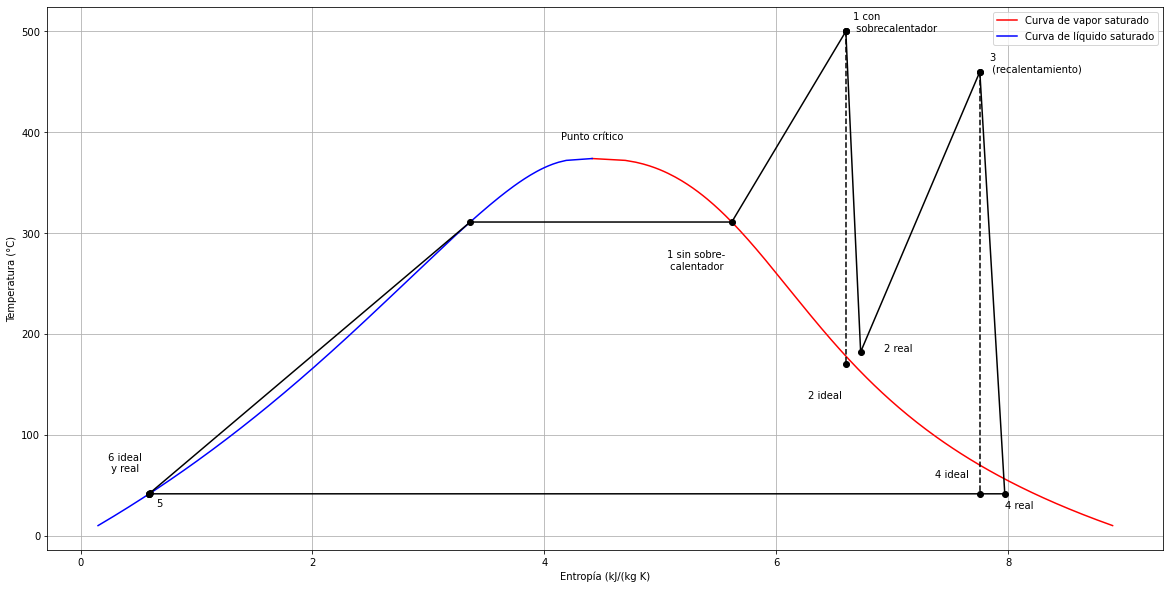

In [21]:
ciclo.mostrar_resultados()
ciclo.pintar_ciclo()

# 5) Ciclo de Rankine regenerativo

Un ciclo de Rankine regenerativo con irreversibilidades en la turbina, trabaja con vapor de agua. El
vapor entra a la turbina a una temperatura de 480 ºC y a una presión de 8 MPa, y se expande hasta
los 0.7 MPa, donde parte del vapor se desvía hacia el intercambiador de calor regenerativo. El vapor
restante se expande en la segunda etapa de la turbina hasta los 0,008 MPa, y sale hacia la bomba
como líquido saturado. Ambos flujos de vapor se mezclan en el intercambiador de calor a una
presión de 0.7 MPa. El trabajo neto del ciclo es de 100 MW. El rendimiento de la turbina (ηt) es
0.85.

In [22]:
#En este ciclo, tras pasar por la primera parte de la turbina, una parte del flujo másico del vapor (gamma) es llevado
#a un calentador (presión constante), mientras que el resto del flujo (1-gamma) pasa a la segunda turbina. Tras ello, es condensado
#y bombeado al calentador, donde ambos flujos másicos vuelven a unirse. Tras ello el flujo total es bombeado a la
#caldera, donde absorbe calor hasta encontrarse en las mismas condiciones iniciales previas a la turbina.
t1 = 480 #[ºC]
p1 = 8 #[MPa]
p2 = 0.7 #Se asume que la presión en el intercambiador de calor es la misma que la del fluido extraído p6 = p2
p3 = 0.008
x4 = 0
#Se asume que tras mezclarse ambos flujos de vapor, el flujo total sale hacia la bomba como líquido saturado
x6 = 0
w_cycle = 100*1000 #[kW]
eta_T = 0.85
#En este caso, se proporciona un único rendimiento de la turbina, se asume que es el mismo para ambas partes
eta_T1 = eta_T2 = eta_T
#Además, no se aportan los rendimientos de las bombas, por lo que se asume que trabajan reversiblemente
eta_P1 = eta_P2 = 1

class RankineCycleRegenerative(object):
    def __init__(self, p1, t1, p2, p3, x4, x6, w_cycle, eta_T1, eta_T2, eta_P1, eta_P2):
        self.t1 = t1
        self.p1 = p1
        self.p2 = p2
        self.p3 = p3
        self.x4 = x4
        self.x6 = x6
        self.w_cycle = w_cycle
        self.eta_T1 = eta_T1
        self.eta_T2 = eta_T2
        self.eta_P1 = eta_P1
        self.eta_P2 = eta_P2
        self.calcular_todo()
        
    def fijar_estados(self):
        self.estado1=State(1, 'Entrada turbina', t=self.t1, p=self.p1)
        self.estado2ideal=State('2i', 'Salida turbina etapa 1 (ideal)', s=self.estado1.s, p=self.p2)
        self.h2r = self.estado1.h-self.eta_T1*(self.estado1.h-self.estado2ideal.h)
        self.estado2=State(2, 'Salida turbina etapa 1 (real)', h=self.h2r, p=self.p2)
        self.estado3ideal=State('3i', 'Salida turbina etapa 2 (ideal)', p=self.p3, s=self.estado2.s)
        self.h3r = self.estado2.h-self.eta_T2*(self.estado2.h-self.estado3ideal.h)
        self.estado3=State(3, 'Salida turbina etapa 2 (real)', h=self.h3r, p=self.p3)
        self.estado4=State(4, 'Salida del condensador', x=self.x4, p=self.p3)
        self.estado5ideal=State('5i', 'Salida bomba 1 (ideal)', p=self.p2, s=self.estado4.s)
        self.h5r=(self.estado5ideal.h-self.estado4.h)/self.eta_P1+self.estado4.h
        self.estado5=State(5, 'Salida bomba 1 (real)', p=self.p2, h=self.h5r)
        self.estado6=State(6, 'Salida calentador', p=self.p2, x=self.x6)
        self.estado7ideal=State('7i', 'Salida bomba 2 (ideal)', p=self.p1, s=self.estado6.s)
        self.h7r=(self.estado7ideal.h-self.estado6.h)/self.eta_P2+self.estado6.h
        self.estado7=State(7, 'Salida bomba 2 (real)', p=self.p1, h=self.h7r)
        self.states_order = [self.estado1, self.estado2, self.estado3, self.estado4, self.estado5, self.estado6, self.estado7]
        self.all_states = [self.estado1, self.estado2ideal, self.estado2, self.estado3ideal, self.estado3, self.estado4,
                             self.estado5ideal, self.estado5, self.estado6, self.estado7ideal, self.estado7]
        
    def calcular_entalpias(self):
        self.w_T1 = self.estado1.h - self.estado2.h
        self.w_T2 = self.estado2.h - self.estado3.h
        self.w_P1 = self.estado5.h - self.estado4.h
        self.w_P2 = self.estado7.h - self.estado6.h
        self.q_in = self.estado1.h - self.estado7.h
        self.q_out = self.estado3.h - self.estado4.h
        
    def calcular_fraccion(self):
        #Para calcular la fracción gamma (porcentaje del flujo másico total que es extraído tras la primera turbina),
        #observaremos los flujos de energía en el calentador:
        #gamma*h2 + (1-gamma)*h5 = gamma*(h2-h5) + h5 = h6
        self.gamma = (self.estado6.h-self.estado5.h)/(self.estado2.h-self.estado5.h)
        
    def calcular_rendimientos(self):
        self.w_turb = self.w_T1 + self.w_T2*(1-self.gamma) 
        #Por la primer turbina pasa todo el flujo másico, mientras que por la segunda pasa el resto del fraccionado
        self.w_pump = self.w_P1*(1-self.gamma) + self.w_P2
        #Por la primera bomba solo pasa el resto del fraccionado y por la segunda pasa el total
        self.eta_th = (self.w_turb - self.w_pump)/self.q_in
        self.bwr = self.w_pump/self.w_turb
               
    def calcular_flujo_masico(self):
        #Se calcula el flujo másico total:
        self.mass_flow = (self.w_cycle)/(self.w_turb - self.w_pump)
        #Además de los dos flujos másicos tras la separación:
        self.extracted_flow = self.gamma*self.mass_flow
        self.rest_flow = self.mass_flow-self.extracted_flow
                    
    def calcular_potencias(self):
        self.w_T1_kw = self.w_T1 * self.mass_flow
        self.w_T2_kw = self.w_T2 * self.rest_flow
        self.w_P1_kw = self.w_P1 * self.rest_flow
        self.w_P2_kw = self.w_P2 * self.mass_flow
        self.q_in_kw = self.q_in * self.mass_flow
        self.q_out_kw = self.q_out * self.rest_flow
        
    def calcular_todo(self):
        self.fijar_estados()
        self.calcular_entalpias()
        self.calcular_fraccion()
        self.calcular_rendimientos()
        self.calcular_flujo_masico()
        self.calcular_potencias()
    
    def hacer_df(self):
        estadosr = {'Presión [MPa]':[self.all_states[k].p for k in range(len(self.all_states))],
                    'Temperatura [ºC]':[self.all_states[k].t for k in range(len(self.all_states))],
                    'Entalpía [kJ/kg]':[self.all_states[k].h for k in range(len(self.all_states))],
                    'Entropía [kJ/kgK]':[self.all_states[k].s for k in range(len(self.all_states))],
                    'Calidad':[self.all_states[k].x for k in range(len(self.all_states))]}
        df = pd.DataFrame(estadosr)
        df.index = ['Estado 1', 'Estado 2 reversible', 'Estado 2 irreversible','Estado 3 reversible','Estado 3 irreversible', 
                   'Estado 4', 'Estado 5 reversible', 'Estado 5 irreversible', 'Estado 6', 'Estado 7 reversible', 'Estado 7 irreversible']
        print('Apartado A)\n')
        return df
            
    def mostrar_resultados(self):
        print(f'Apartado B)\n El rendimiento térmico es: eta = {self.eta_th:.3f}.\n El back work ratio es: bwr = {self.bwr:.3f}.')
        print(f'Apartado C)\n El flujo de masa de vapor total es: m_dot = {self.mass_flow:.3f} kg/s,\n El flujo de masa extraído tras la primera etapa de la turbina es: m_extr = {self.extracted_flow:.3f} kg/s\n y el flujo que pasa por la segunda etapa de la turbina es: m_rest = {self.rest_flow:.3f} kg/s.')
#         print(
#             f'El calor introducido por la caldera es Qin = {self.q_in:.2f} KJ/kg, Qout = {self.q_out:.2f}  KJ/kg, Wt1 = {self.w_t1:.2f} KJ/kg, '
#             f'Wt2 = {self.w_t2:.2f} KJ/kg, Wp = {self.w_p:.2f} KJ/kg')
        print(f'El calor introducido por la caldera es: Qin = {self.q_in_kw:.2f} kW,\n el extraído por el condensador es: Qout = {self.q_out_kw:.2f} kW.')
        print(f'El trabajo de la primera etapa de turbina es: Wt1 = {self.w_T1_kw:.2f} kW,\n el trabajo de la segunda etapa es: Wt2 = {self.w_T2_kw:.2f} kW\n y el trabajo de las bombas es: Wp = {(self.w_P1_kw+self.w_P2_kw):.2f} kW.')
        
    def pintar_ciclo(self):
        print('Apartado D)\n')
        Tc = 647.096 - 273.15 #Temperatura del punto crítico [ºC]
        plt.figure(figsize=(20.0,10.0))
        # Líneas de líquido y vapor saturado 
        npt = np.linspace(10,Tc,200) # range of temperatures
        svap = [s for s in [tx2s(t, 1) for t in npt]]
        sliq = [s for s in [tx2s(t, 0) for t in npt]]
        plt.plot(svap, npt, 'r-')
        plt.plot(sliq, npt, 'b-')
        plt.legend(['Curva de vapor saturado','Curva de líquido saturado'])

        t=[self.states_order[k].t for k in range(len(self.states_order))]
        s=[self.states_order[k].s for k in range(len(self.states_order))]

        # Es necesario añadir los puntos de líquido y vapor saturado a p1 para definir la curva y finalizar en el punto de partida
        self.estado_a = State('a', p=self.estado1.p, x=0)
        self.estado_b = State('b', p=self.estado1.p, x=1)
        t.append(self.estado_a.t)
        t.append(self.estado_b.t)
        t.append(self.estado1.t)
        s.append(self.estado_a.s)
        s.append(self.estado_b.s)
        s.append(self.estado1.s)
        plt.plot(s, t, 'ko-')

        #Marcamos el recorrido del turbinado ideal de la primera etapa
        tTi1=[self.estado1.t,self.estado2ideal.t]
        sTi1=[self.estado1.s,self.estado2ideal.s]
        plt.plot(sTi1, tTi1, 'ko--')
        
        #Marcamos el recorrido del turbinado ideal de la segunda etapa
        tTi2=[self.estado2.t,self.estado3ideal.t]
        sTi2=[self.estado2.s,self.estado3ideal.s]
        plt.plot(sTi2, tTi2, 'ko--')

        #Marcamos el recorrido del bombeado ideal
        tPi1=[self.estado4.t,self.estado5ideal.t]
        sPi1=[self.estado4.s,self.estado5ideal.s]
        plt.plot(sPi1, tPi1, 'ko--')
        tPi2=[self.estado6.t,self.estado7ideal.t]
        sPi2=[self.estado6.s,self.estado7ideal.s]
        plt.plot(sPi2, tPi2, 'ko--')
        
        #Marcamos la parte regenerada en el ciclo
        #Si tras el primer turbinado nos encontramos en la zona de vapor sobrecalentado, pintaremos también
        #hasta el punto de vapor saturado
        if self.estado2.t > self.estado6.t:
            self.estado_c = State('c', p=self.estado2.p, x=1)
            tR=[self.estado2.t, self.estado_c.t, self.estado6.t]
            sR=[self.estado2.s, self.estado_c.s, self.estado6.s]
            plt.plot(sR, tR, 'go-')
        else:
            tR=[self.estado2.t, self.estado6.t]
            sR=[self.estado2.s, self.estado6.s]
            plt.plot(sR, tR, 'go-')
        
        plt.xlabel('Entropía (kJ/(kg K)')
        plt.ylabel('Temperatura (°C)')
        
        plt.annotate('1',xy=[self.estado1.s*1.01,self.estado1.t])
        plt.annotate('2 real',xy=[self.estado2.s*1.03,self.estado2.t])
        plt.annotate('2 ideal',xy=[self.estado2ideal.s*0.95,self.estado2ideal.t*1.02])
        plt.annotate('3 real',xy=[self.estado3.s*1.01,self.estado3.t*1.02])
        plt.annotate('3 ideal',xy=[self.estado3ideal.s*0.95,self.estado3ideal.t*0.8])
        plt.annotate('4',xy=[self.estado4.s*1.04,self.estado4.t*0.65])
        plt.annotate('5 ideal\n y real',xy=[self.estado5.s*0.55,self.estado5.t*1.03])
        plt.annotate('6',xy=[self.estado6.s*1.02,self.estado6.t*0.9])
        plt.annotate('7 ideal\n y real',xy=[self.estado7.s*0.82,self.estado7.t])
        plt.annotate('Punto crítico',xy=[(tx2s(Tc, 1))*0.94,(Tc)*1.05])
        plt.grid()
    

In [23]:
ciclo = RankineCycleRegenerative(p1, t1, p2, p3, x4, x6, w_cycle, eta_T1, eta_T2, eta_P1, eta_P2)
df = ciclo.hacer_df()
df

Apartado A)



,Presión [MPa],Temperatura [ºC],Entalpía [kJ/kg],Entropía [kJ/kgK],Calidad
Estado 1,8.000,480.000000,3349.526690,6.661057,1.000000
Estado 2 reversible,0.700,164.952753,2742.628701,6.661057,0.990259
Estado 2 irreversible,0.700,194.850287,2833.663399,6.863660,1.000000
Estado 3 reversible,0.008,41.510053,2147.121446,6.863660,0.821379
Estado 3 irreversible,0.008,41.510053,2250.102739,7.190938,0.864245
Estado 4,0.008,41.510053,173.851769,0.592532,0.000000
Estado 5 reversible,0.700,41.530893,174.549528,0.592532,0.000000
Estado 5 irreversible,0.700,41.530893,174.549528,0.592532,0.000000
Estado 6,0.700,164.952753,697.143361,1.992083,0.000000
Estado 7 reversible,8.000,165.854570,705.215718,1.992083,0.000000


Apartado B)
 El rendimiento térmico es: eta = 0.369.
 El back work ratio es: bwr = 0.009.
Apartado C)
 El flujo de masa de vapor total es: m_dot = 102.448 kg/s,
 El flujo de masa extraído tras la primera etapa de la turbina es: m_extr = 20.134 kg/s
 y el flujo que pasa por la segunda etapa de la turbina es: m_rest = 82.314 kg/s.
El calor introducido por la caldera es: Qin = 270904.58 kW,
 el extraído por el condensador es: Qout = 170904.58 kW.
El trabajo de la primera etapa de turbina es: Wt1 = 52849.20 kW,
 el trabajo de la segunda etapa es: Wt2 = 48035.23 kW
 y el trabajo de las bombas es: Wp = 884.43 kW.
Apartado D)



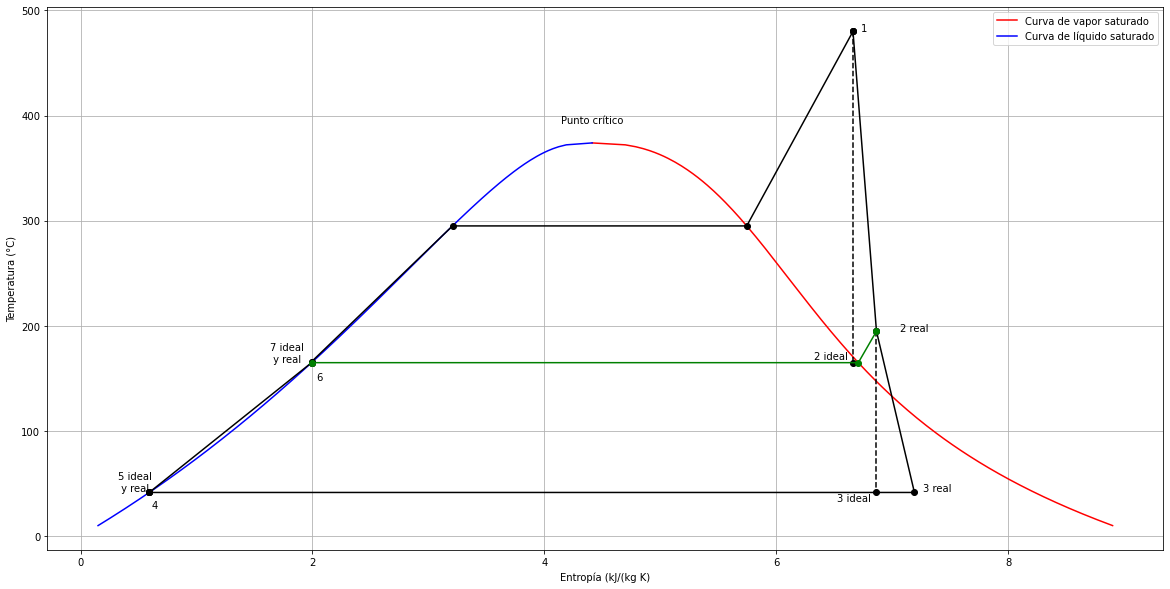

In [24]:
ciclo.mostrar_resultados()
ciclo.pintar_ciclo()

# 6) Análisis de sensibilidad

Se tomará el ciclo de Rankine regenerativo para este análisis. Se procederá a comparar los resultados obtenidos variando los valores que aportamos para el cálculo del ciclo.

In [25]:
# Vamos a utilizar el regenerativo y ver como varían los resultados principales (flujos másicos, rendimientos, potencias, 
#calores) según variamos los inputs.

#Representamos los datos con matplotlib
# Haremos el gráfico para cada resultado principal y esto además para cada variable
def graficar(valor, stringval, variable, stringvar):
    plt.figure(figsize=(11,5))
    plt.plot(variable, valor)
    plt.xlabel("{}".format(stringvar))
    plt.ylabel("{}".format(stringval))
    plt.title('Análisis de sensibilidad de {} para distintas {}.'.format(stringval, stringvar))
    plt.grid()
    plt.show()
    
def graficar_todo(flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento, variable, stringvar):
    graficar(flujomasa, 'flujo másico', variable, stringvar)
    graficar(flujoextr, 'flujo extraído', variable, stringvar)
    graficar(potTurb1, 'potencia turbina 1', variable, stringvar)
    graficar(potTurb2, 'potencia turbina 2', variable, stringvar)
    graficar(potBomb1, 'potencia bomba 1', variable, stringvar)
    graficar(potBomb2, 'potencia bomba 2', variable, stringvar)
    graficar(calorIn, 'calor de la caldera', variable, stringvar)
    graficar(calorOut, 'calor del condensador', variable, stringvar)
    graficar(rendimiento, 'rendimiento térmico', variable, stringvar)
    
def redefinir():
    flujomasa = []
    flujoextr = []
    potTurb1 = []
    potTurb2 = []
    potBomb1 = []
    potBomb2 = []
    calorIn = []
    calorOut = []
    rendimiento = []
    return flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento

def añadir(flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento, ciclo):
    flujomasa.append(ciclo.mass_flow)
    flujoextr.append(ciclo.extracted_flow)
    potTurb1.append(ciclo.w_T1_kw)
    potTurb2.append(ciclo.w_T2_kw)
    potBomb1.append(ciclo.w_P1_kw)
    potBomb2.append(ciclo.w_P2_kw)
    calorIn.append(ciclo.q_in_kw)
    calorOut.append(ciclo.q_out_kw)
    rendimiento.append(ciclo.eta_th)
    return flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento

p1 = 8 #[MPa]
t1 = 480 #[ºC]
p2 = 0.7
p3 = 0.008
x4 = 0
x6 = 0
w_cycle = 100*1000 #[kW]
eta_T = 0.85
eta_T1 = eta_T2 = eta_T
eta_P1 = eta_P2 = 1
flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento = redefinir()


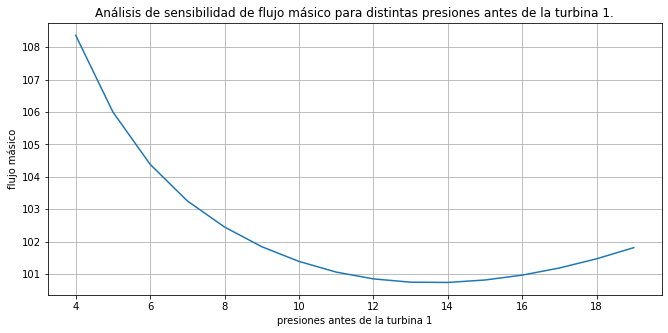

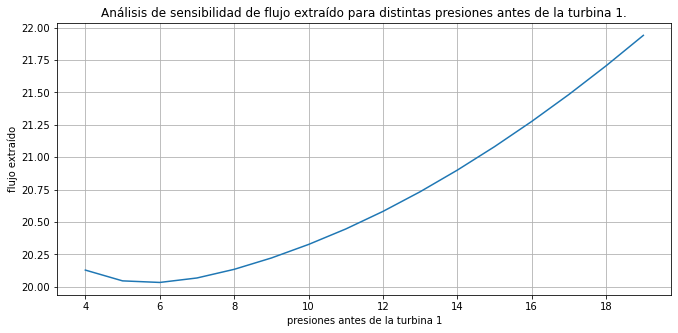

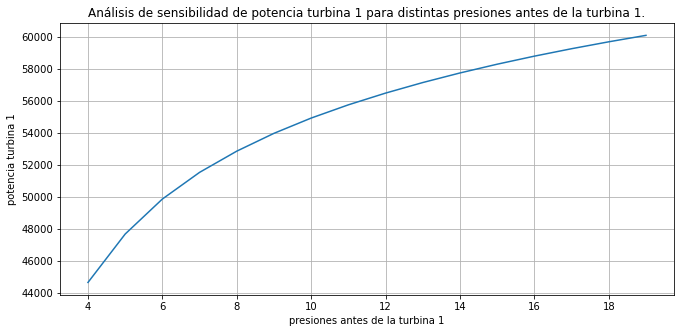

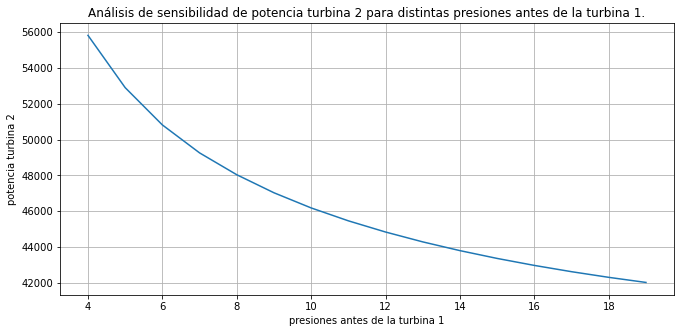

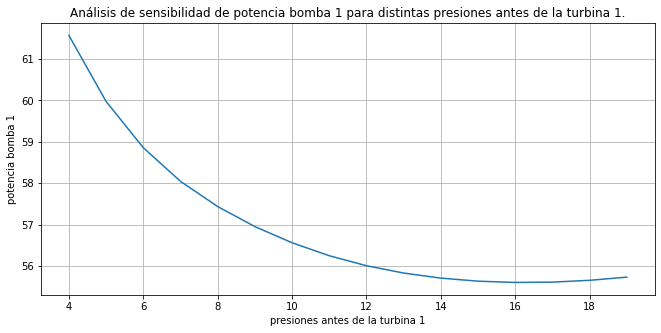

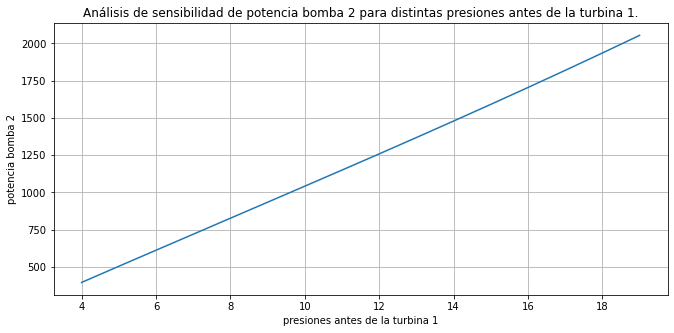

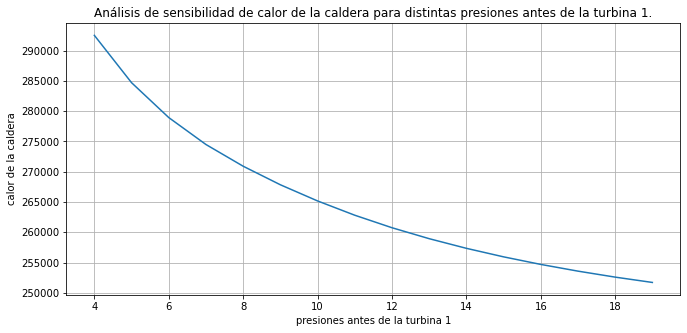

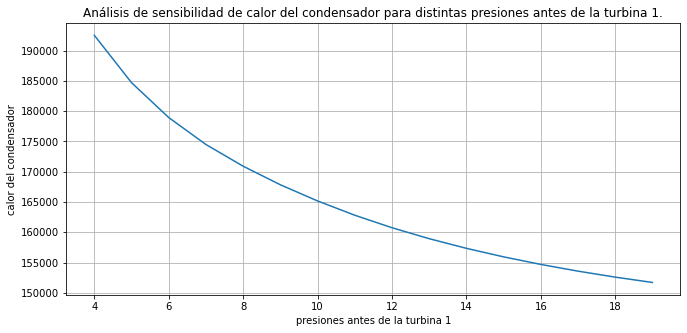

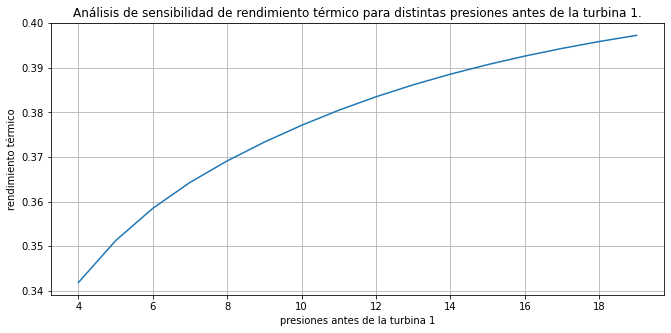

In [26]:
#Variando la presión antes de la turbina y ceteris paribus
p1 = [i for i in range(4,20)]
for p in p1:
    ciclo1 = RankineCycleRegenerative(p, t1, p2, p3, x4, x6, w_cycle, eta_T1, eta_T2, eta_P1, eta_P2)
    añadir(flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento, ciclo1)

#Potencias y calores en kW, flujos en kg/s y presiones en MPa
graficar_todo(flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento, p1, 'presiones antes de la turbina 1')

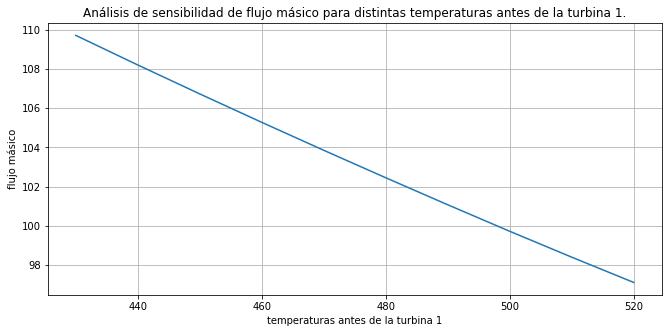

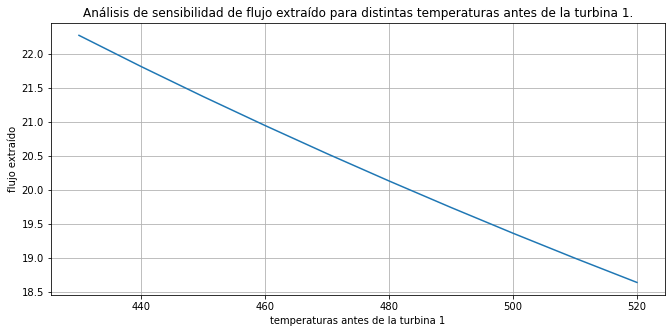

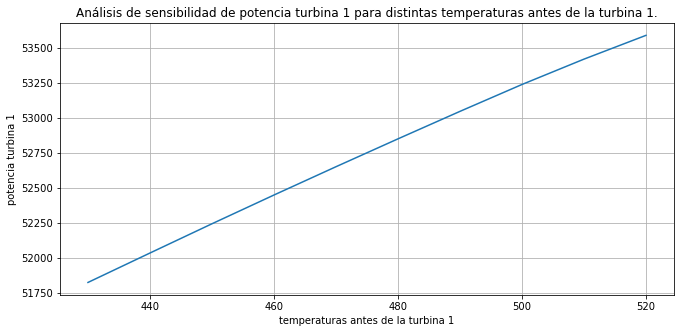

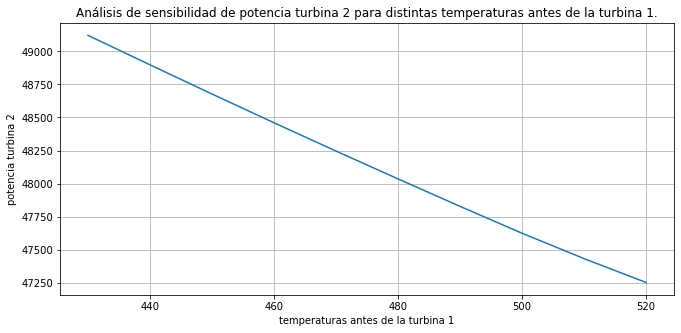

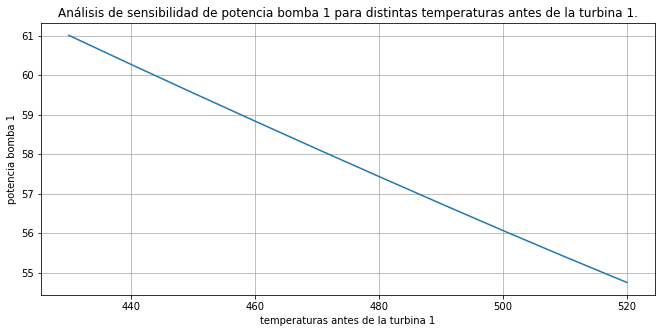

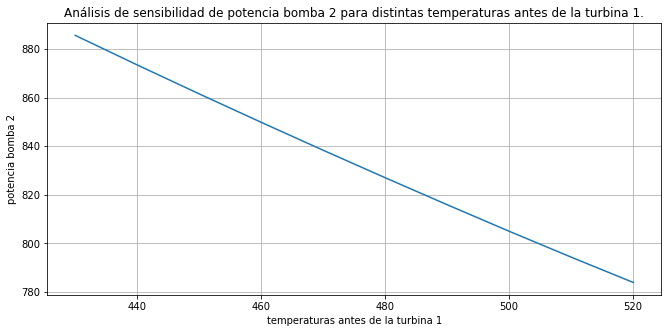

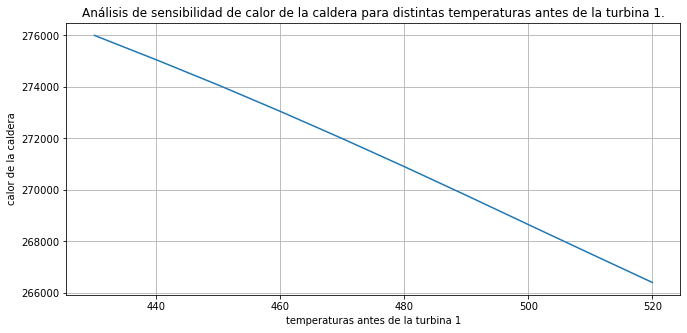

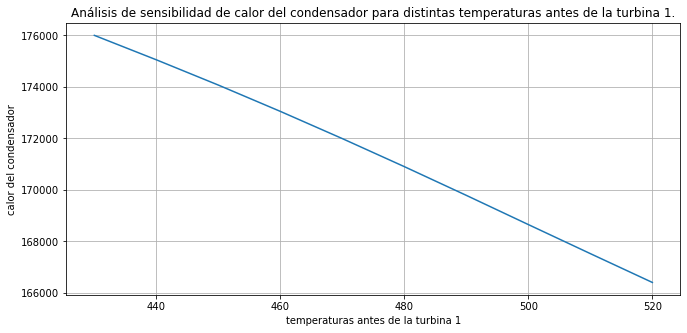

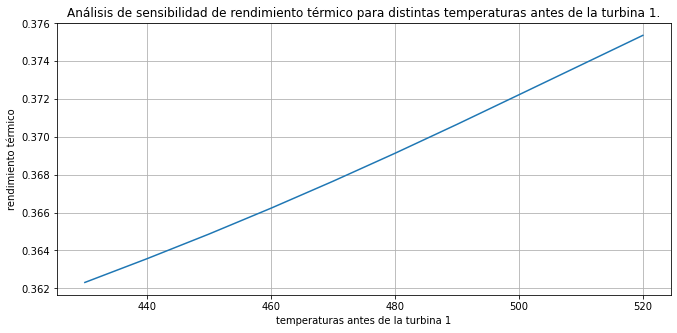

In [27]:
#Variando la temperatura antes de la turbina y ceteris paribus
p1 = 8 #[MPa]
t1 = [i for i in range(430,530,10)]
flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento = redefinir()
for t in t1:
    ciclo2 = RankineCycleRegenerative(p1, t, p2, p3, x4, x6, w_cycle, eta_T1, eta_T2, eta_P1, eta_P2)
    añadir(flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento, ciclo2)

#Potencias y calores en kW, flujos en kg/s y temperaturas en ºC
graficar_todo(flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento, t1, 'temperaturas antes de la turbina 1')

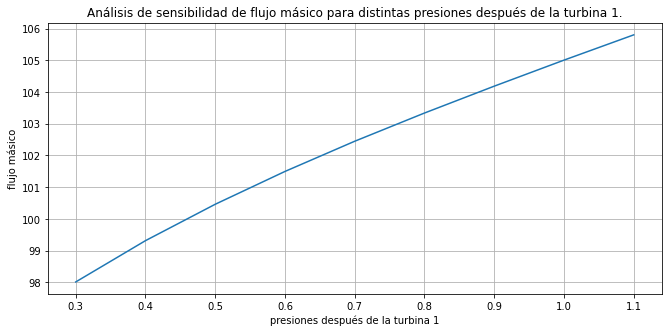

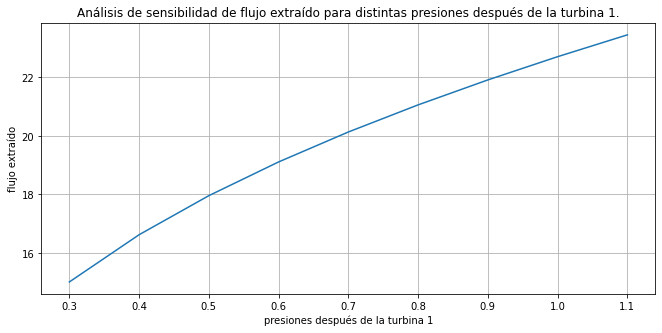

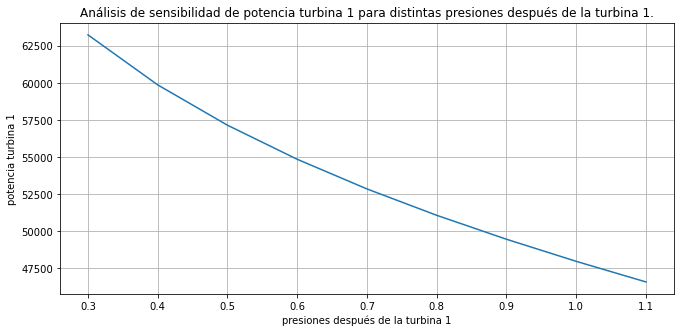

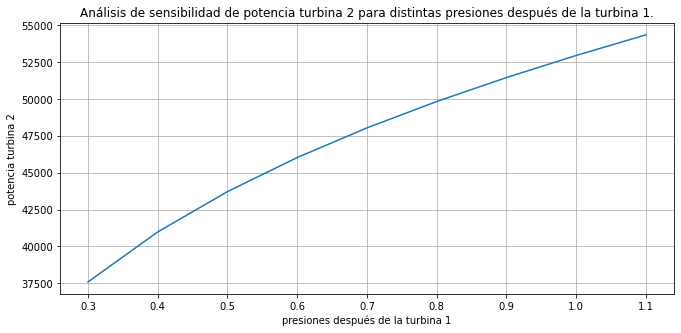

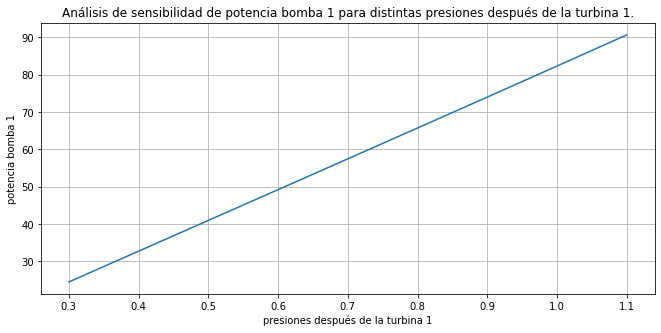

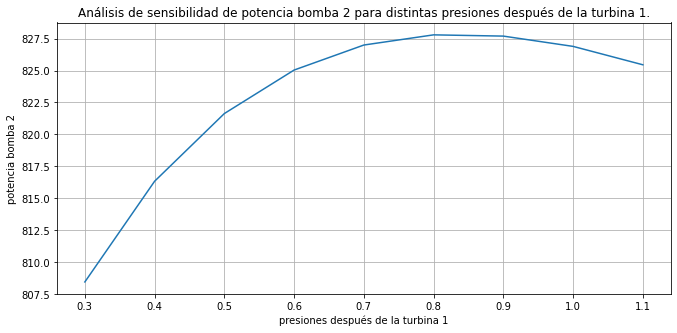

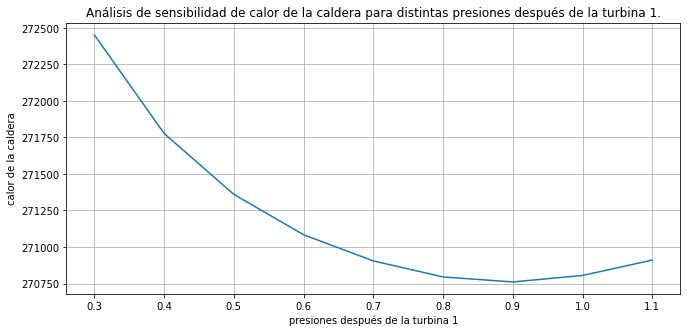

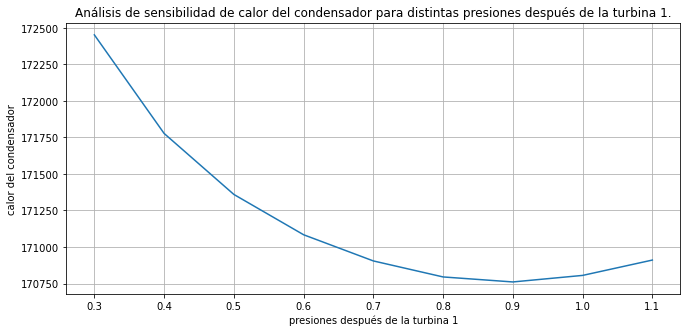

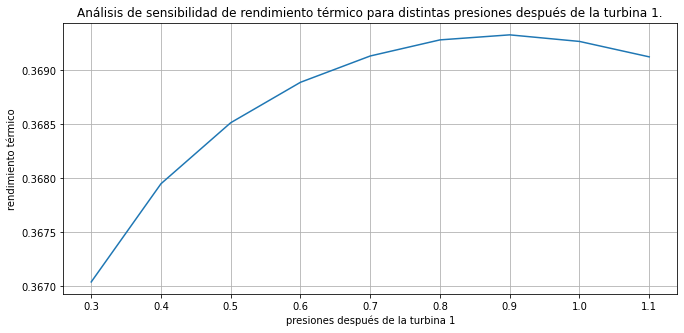

In [28]:
#Variando la presión después de la turbina 1 y ceteris paribus
t1 = 480 #[ºC]
p2 = [i for i in np.arange(0.3,1.2,0.1)] #range() no funciona con float
flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento = redefinir()
for p in p2:
    ciclo3 = RankineCycleRegenerative(p1, t1, p, p3, x4, x6, w_cycle, eta_T1, eta_T2, eta_P1, eta_P2)
    añadir(flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento, ciclo3)

#Potencias y calores en kW, flujos en kg/s y presiones en MPa
graficar_todo(flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento, p2, 'presiones después de la turbina 1')

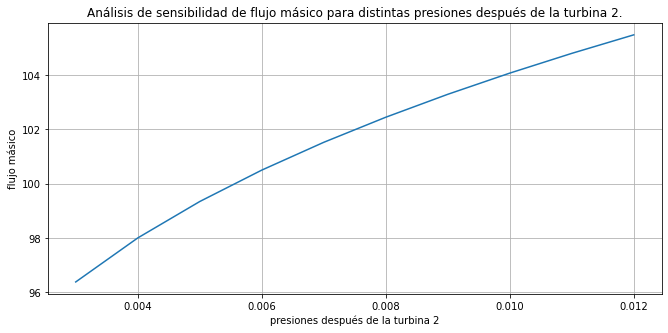

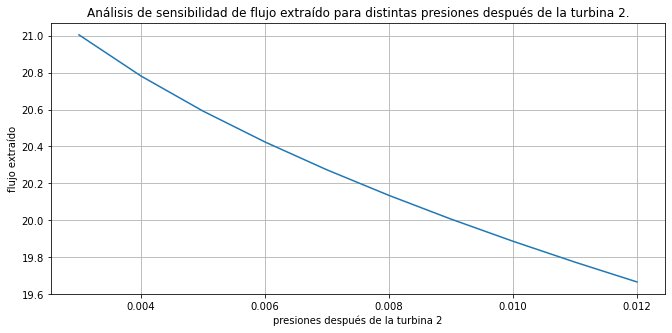

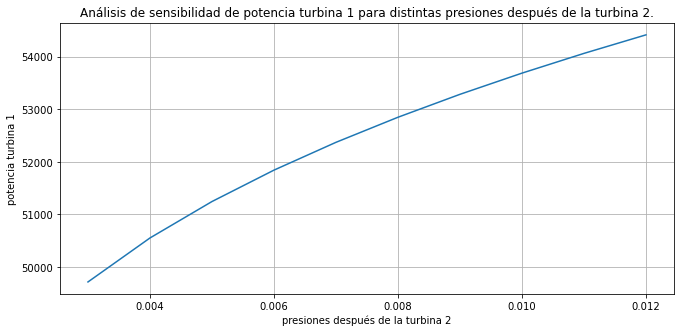

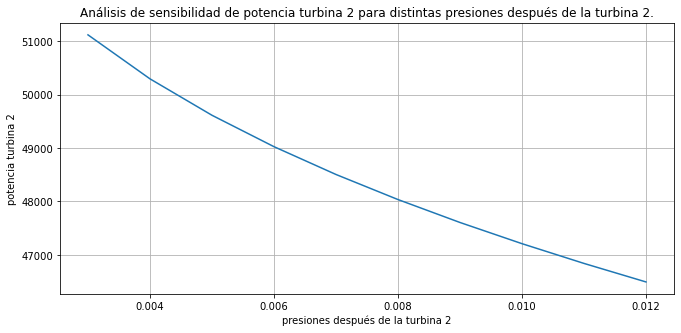

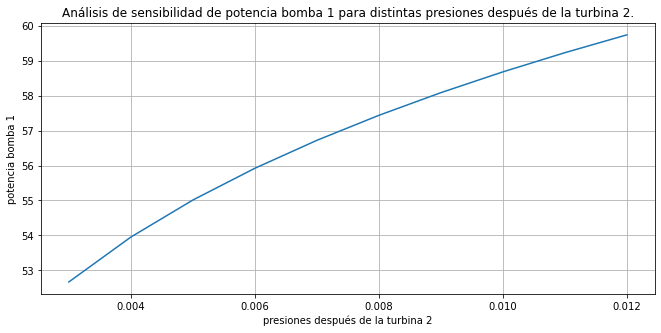

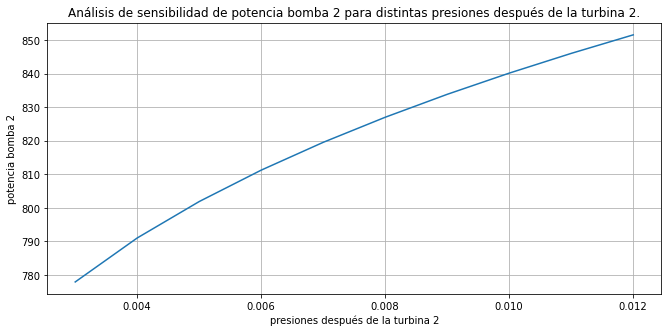

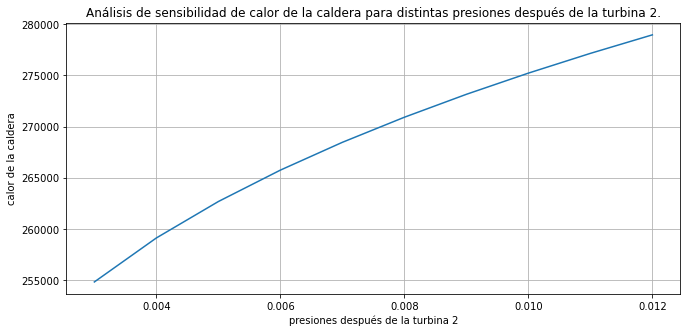

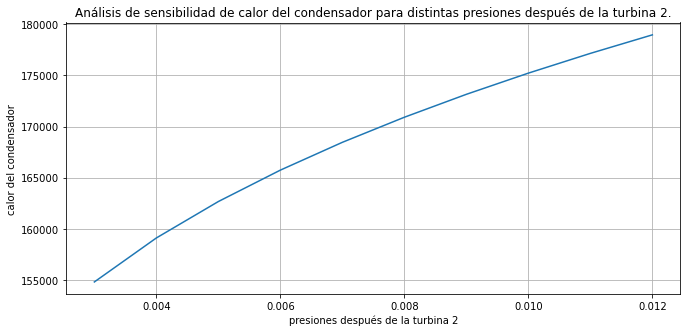

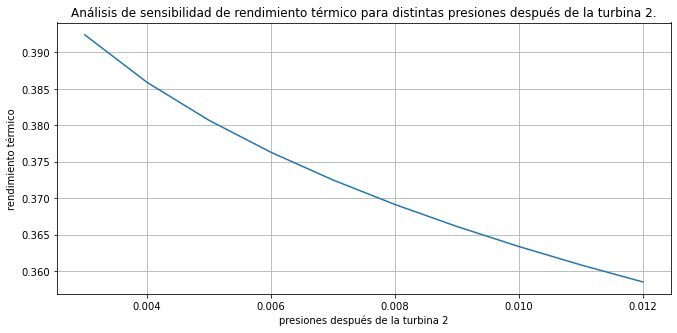

In [29]:
#Variando la presión después de la turbina 2 y ceteris paribus
p2 = 0.7 #[ºC]
p3 = [i for i in np.arange(0.003,0.013,0.001)] #range() no funciona con float
flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento = redefinir()
for p in p3:
    ciclo4 = RankineCycleRegenerative(p1, t1, p2, p, x4, x6, w_cycle, eta_T1, eta_T2, eta_P1, eta_P2)
    añadir(flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento, ciclo4)

#Potencias y calores en kW, flujos en kg/s y presiones en MPa
graficar_todo(flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento, p3, 'presiones después de la turbina 2')

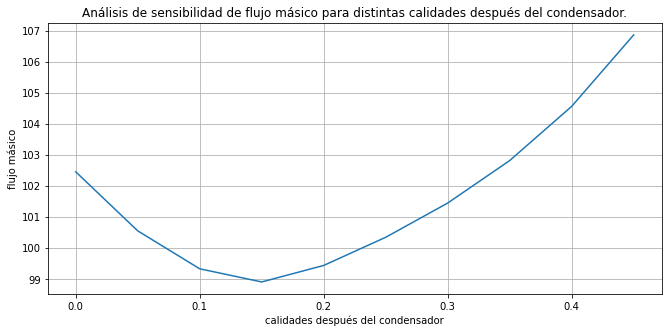

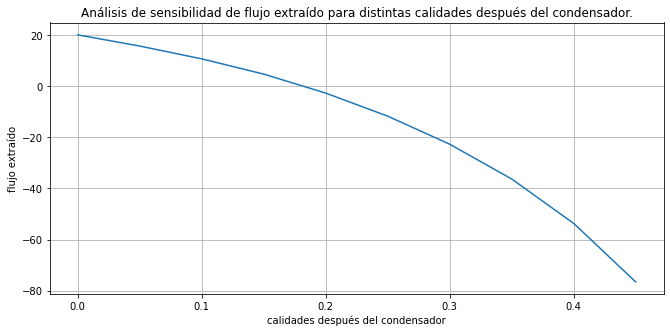

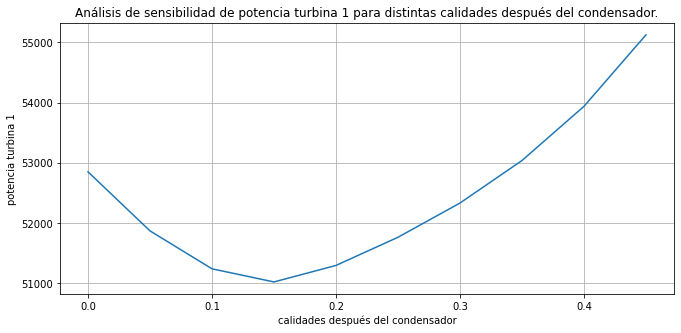

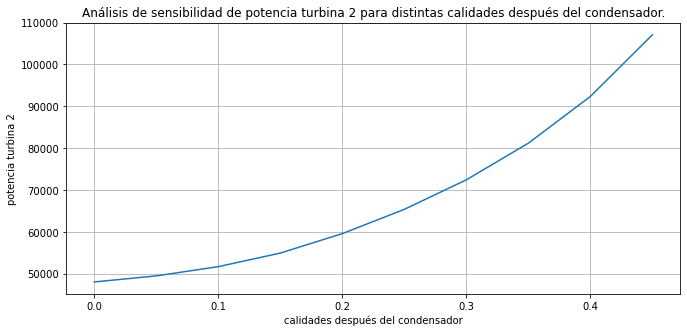

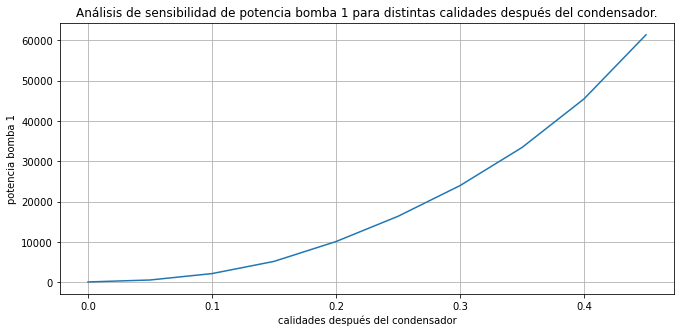

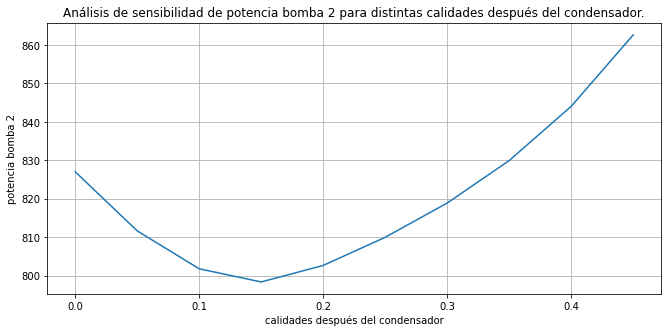

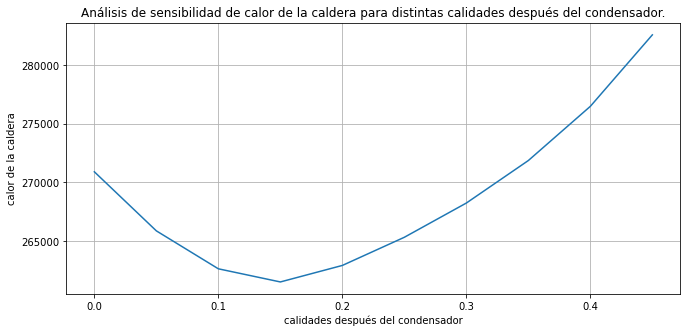

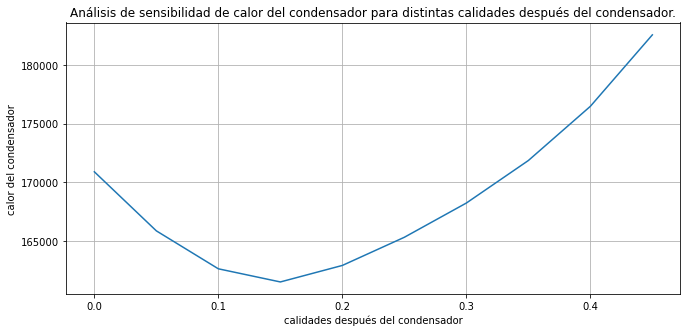

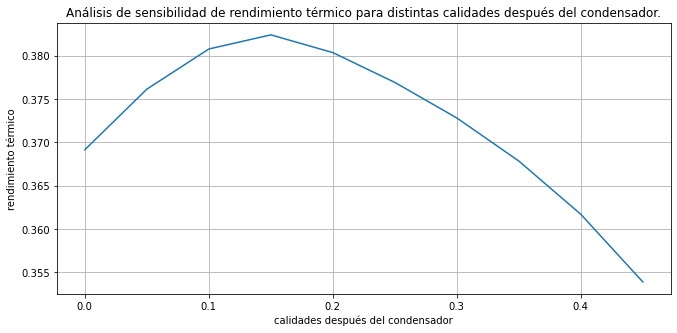

In [30]:
#Variando la calidad después del condensador y ceteris paribus
p3 = 0.008 #[MPa]
x4 = [i for i in np.arange(0,0.5,0.05)] #range() no funciona con float
flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento = redefinir()
for x in x4:
    ciclo5 = RankineCycleRegenerative(p1, t1, p2, p3, x, x6, w_cycle, eta_T1, eta_T2, eta_P1, eta_P2)
    añadir(flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento, ciclo5)

#Potencias y calores en kW, flujos en kg/s
graficar_todo(flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento, x4, 'calidades después del condensador')

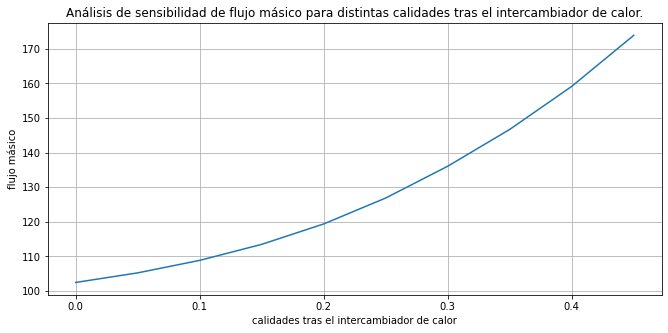

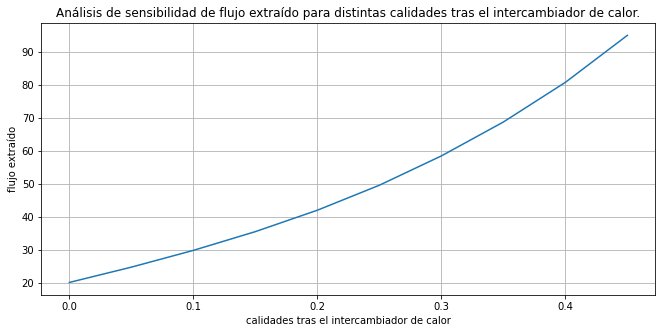

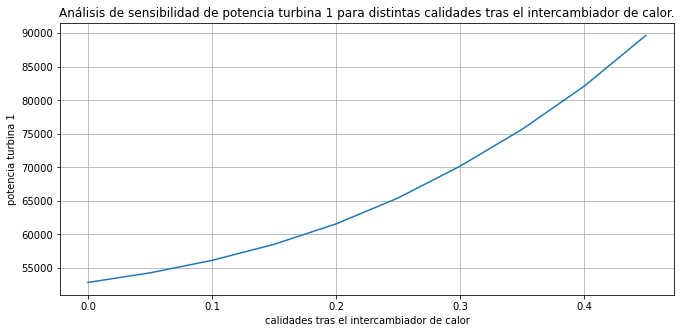

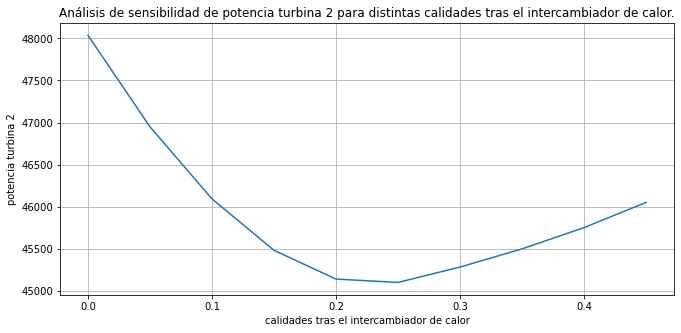

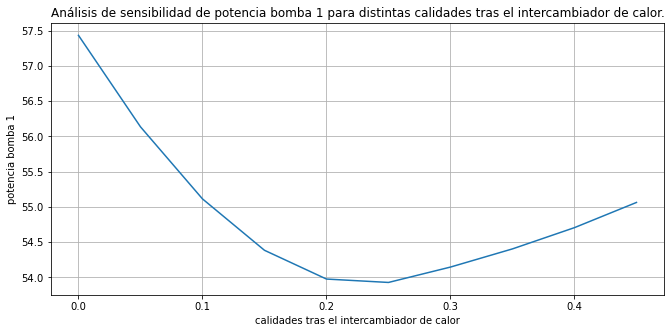

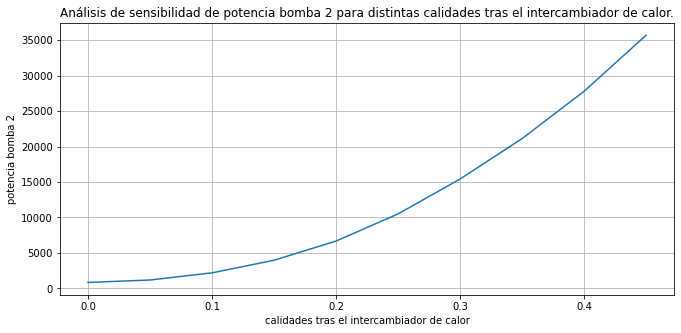

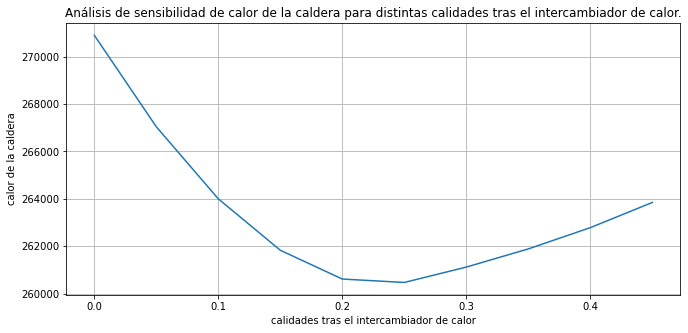

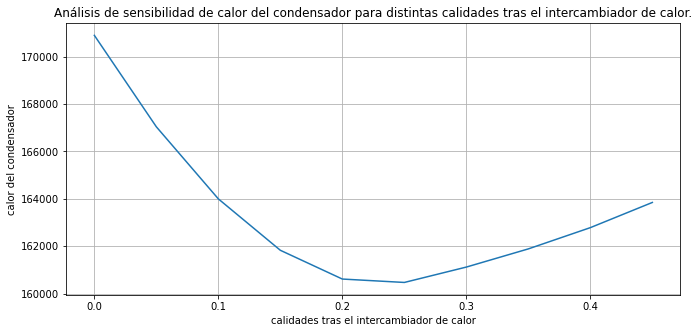

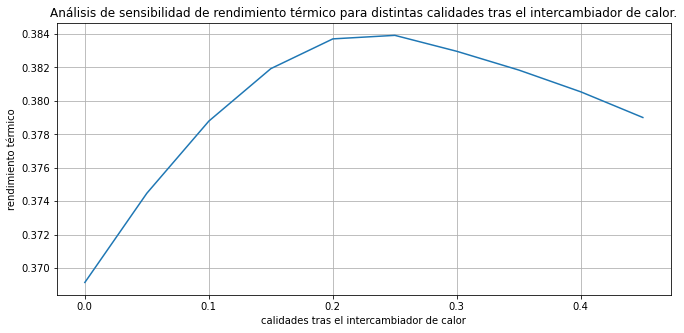

In [31]:
#Variando la calidad tras el intercambiador de calor y ceteris paribus
x4 = 0
x6 = [i for i in np.arange(0,0.5,0.05)] #range() no funciona con float
flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento = redefinir()
for x in x6:
    ciclo6 = RankineCycleRegenerative(p1, t1, p2, p3, x4, x, w_cycle, eta_T1, eta_T2, eta_P1, eta_P2)
    añadir(flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento, ciclo6)

#Potencias y calores en kW, flujos en kg/s
graficar_todo(flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento, x6, 'calidades tras el intercambiador de calor')

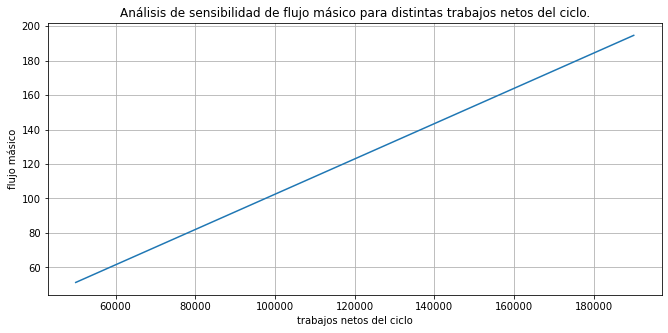

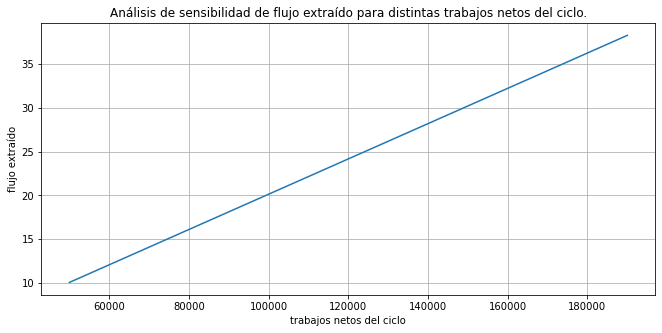

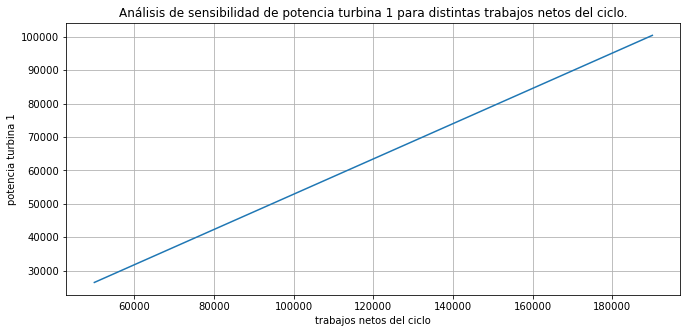

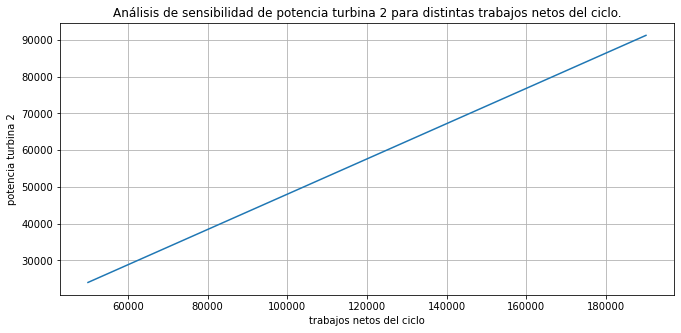

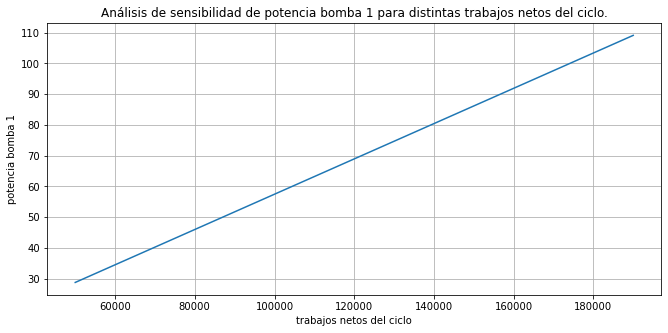

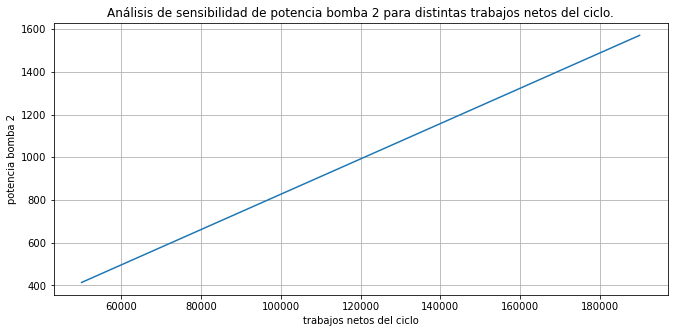

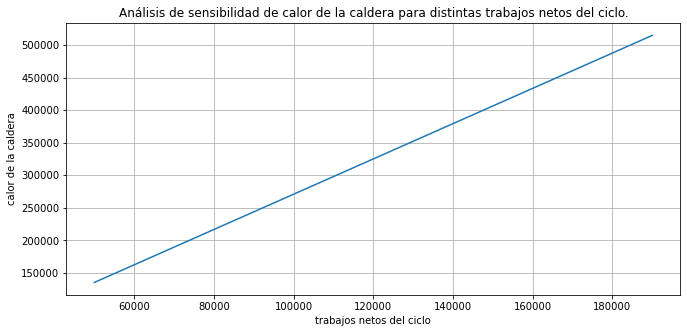

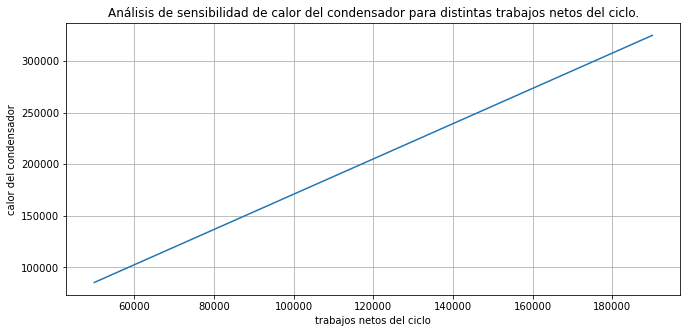

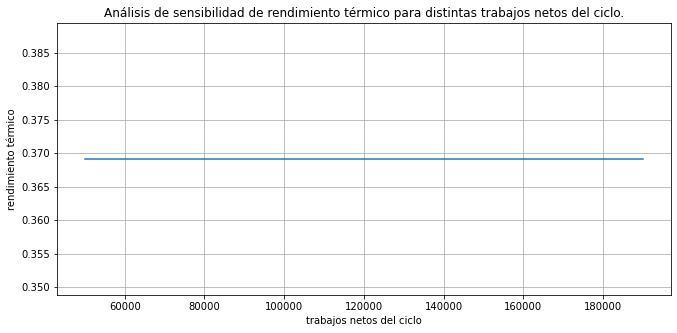

In [32]:
#Variando el trabajo neto del ciclo y ceteris paribus
x6 = 0
w_cycle = [i for i in np.arange(50000, 200000, 10000)] #range() no funciona con float
flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento = redefinir()
for w in w_cycle:
    ciclo7 = RankineCycleRegenerative(p1, t1, p2, p3, x4, x6, w, eta_T1, eta_T2, eta_P1, eta_P2)
    añadir(flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento, ciclo7)

#Potencias y calores en kW, flujos en kg/s
graficar_todo(flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento, w_cycle, 'trabajos netos del ciclo')

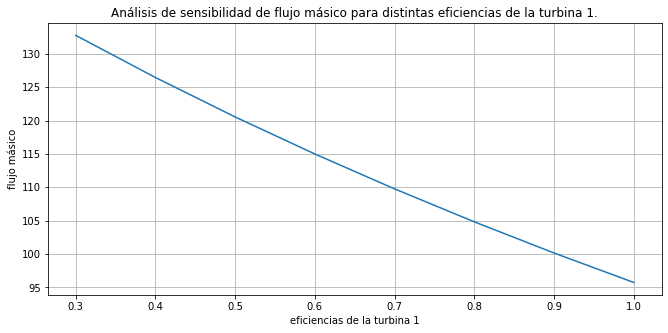

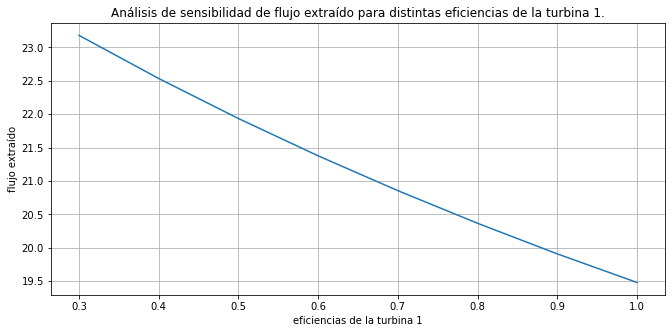

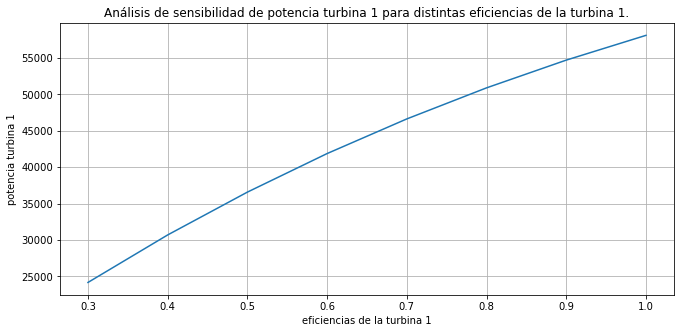

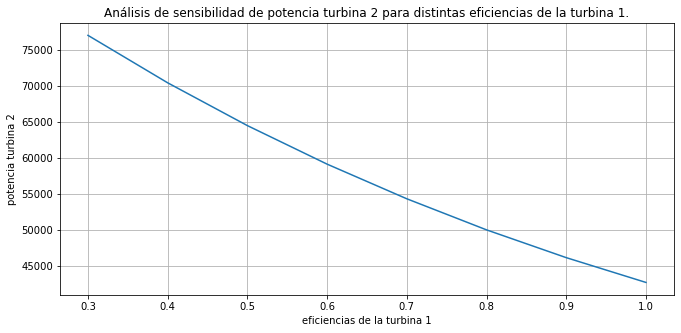

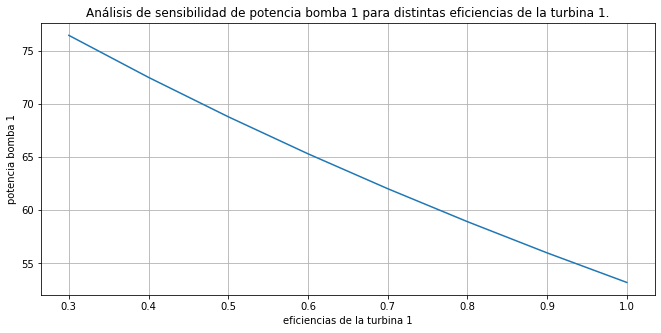

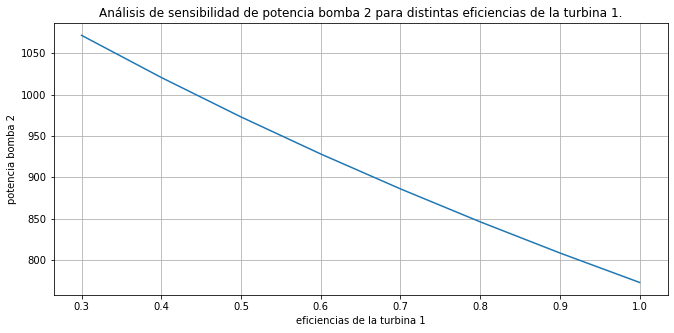

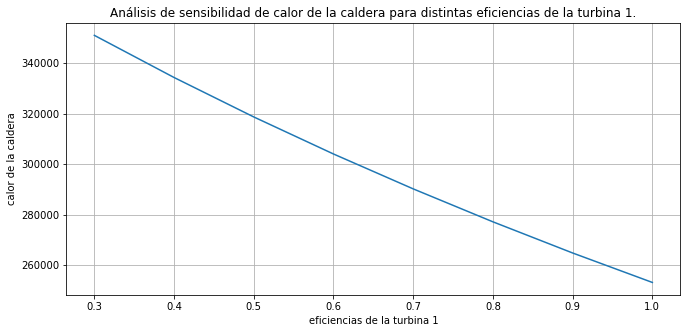

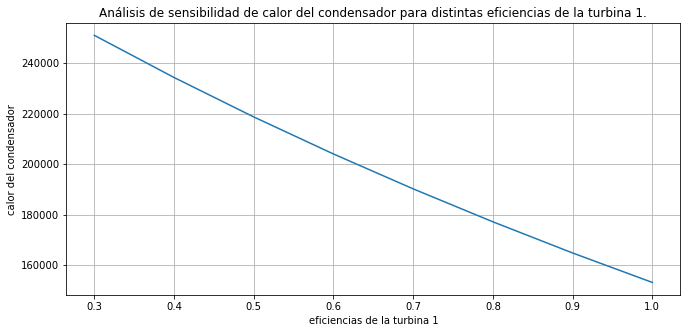

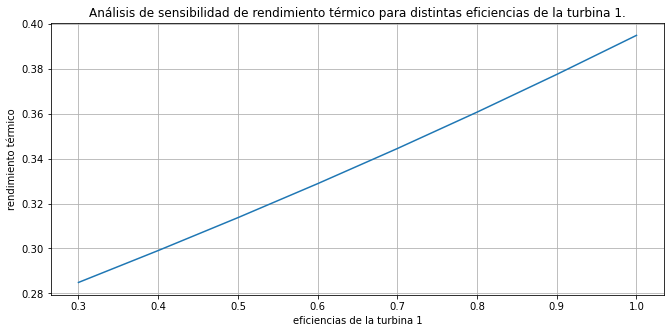

In [33]:
#Variando la eficiencia de la turbina 1 y ceteris paribus
w_cycle = 100000
eta_T1 = [i for i in np.arange(0.3, 1.1, 0.1)] #range() no funciona con float
flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento = redefinir()
for eta in eta_T1:
    ciclo8 = RankineCycleRegenerative(p1, t1, p2, p3, x4, x6, w_cycle, eta, eta_T2, eta_P1, eta_P2)
    añadir(flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento, ciclo8)

#Potencias y calores en kW, flujos en kg/s
graficar_todo(flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento, eta_T1, 'eficiencias de la turbina 1')

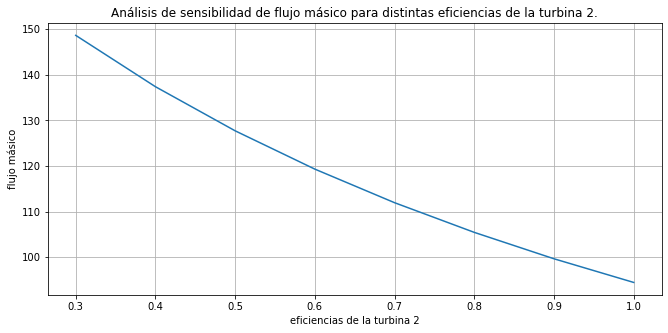

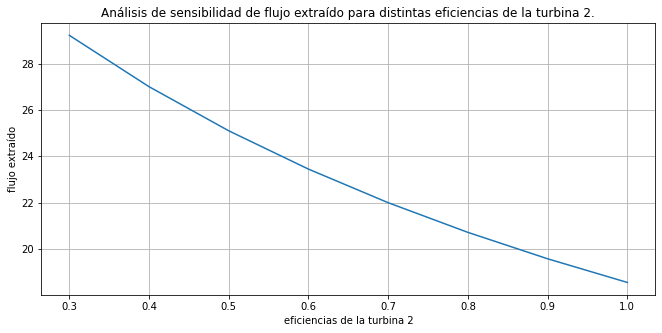

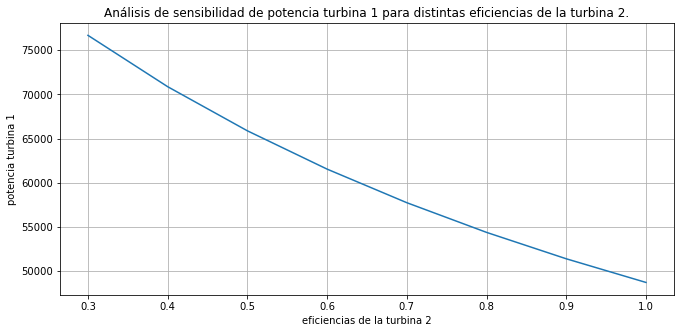

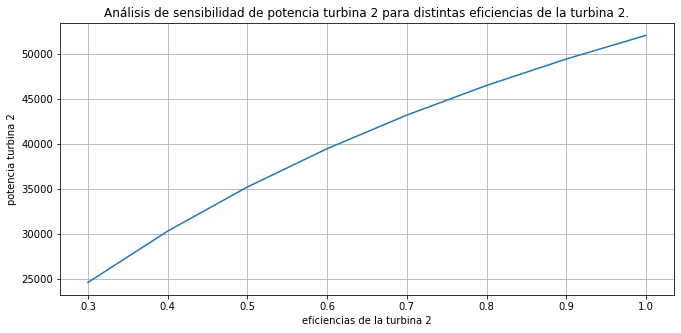

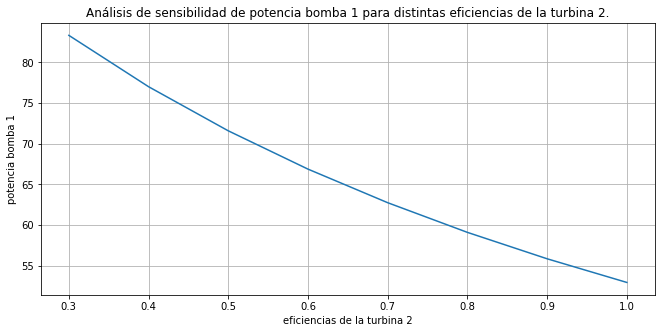

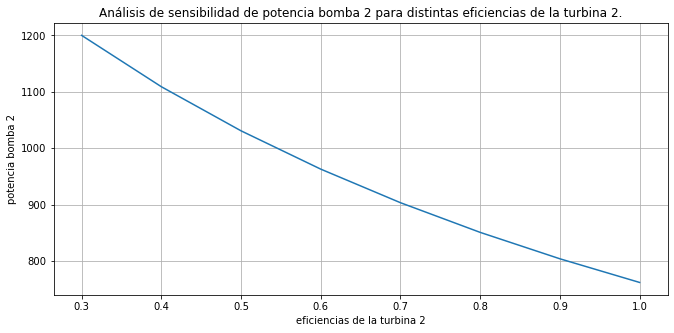

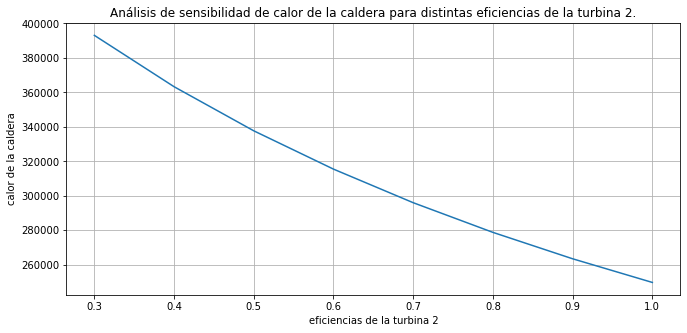

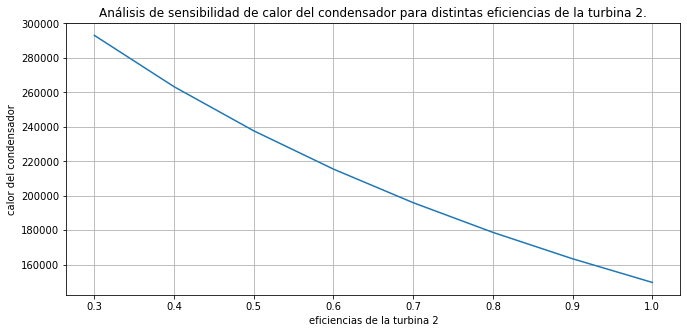

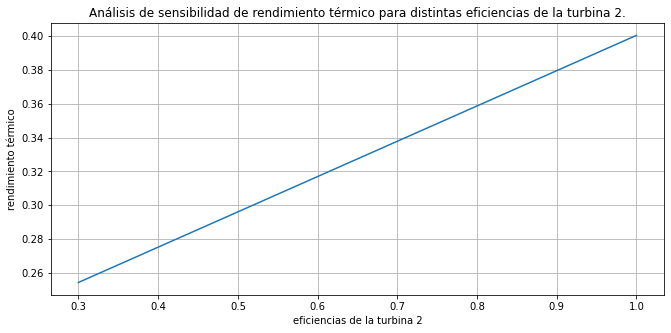

In [34]:
#Variando la eficiencia de la turbina 2 y ceteris paribus
eta_T1 = 0.85
eta_T2 = [i for i in np.arange(0.3, 1.1, 0.1)] #range() no funciona con float
flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento = redefinir()
for eta in eta_T2:
    ciclo9 = RankineCycleRegenerative(p1, t1, p2, p3, x4, x6, w_cycle, eta_T1, eta, eta_P1, eta_P2)
    añadir(flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento, ciclo9)

#Potencias y calores en kW, flujos en kg/s
graficar_todo(flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento, eta_T2, 'eficiencias de la turbina 2')

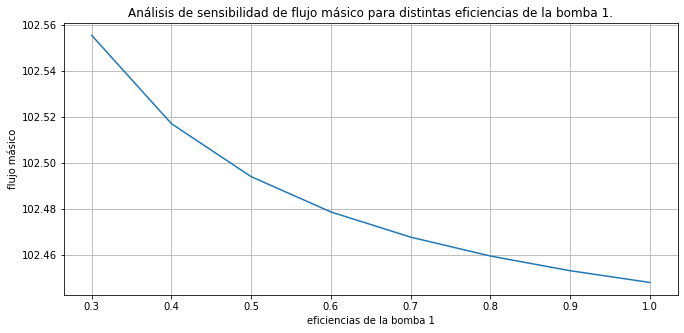

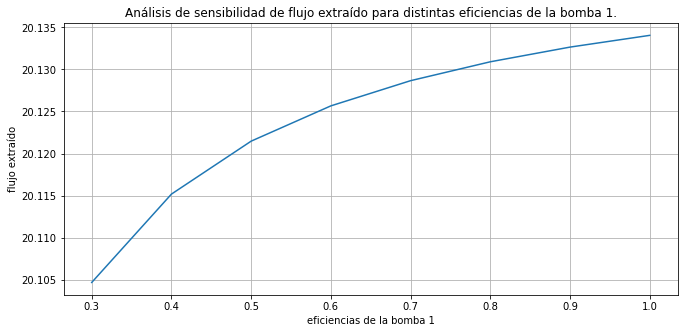

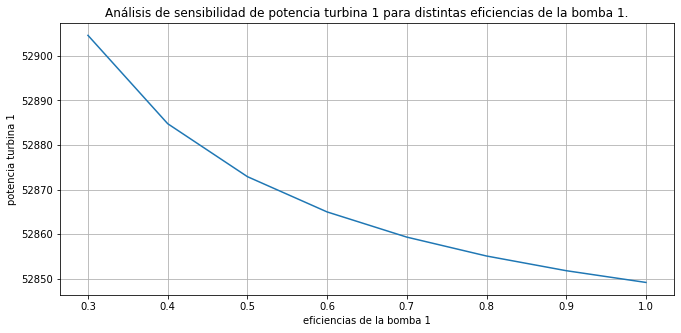

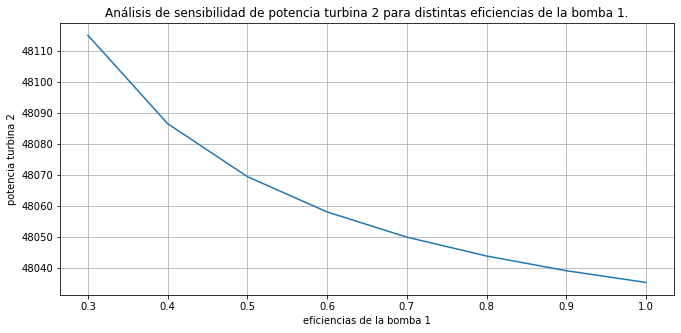

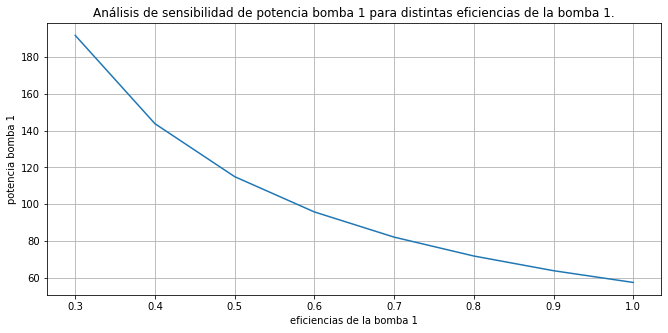

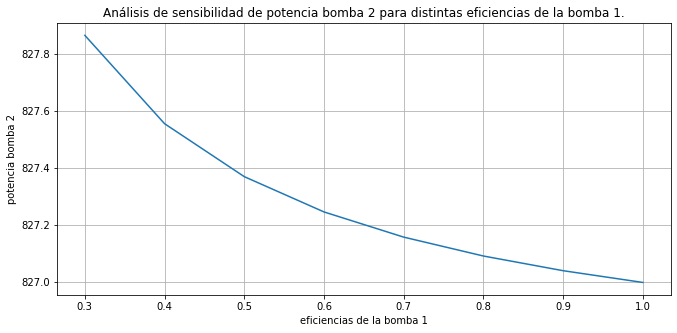

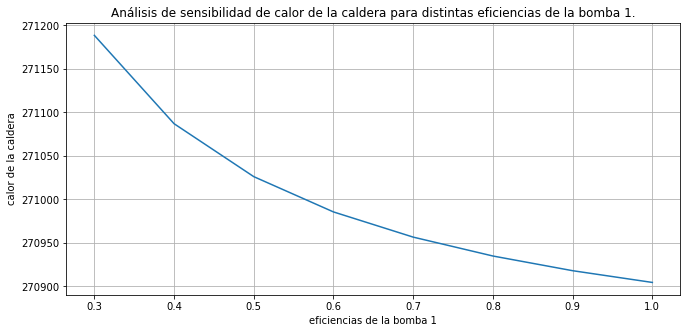

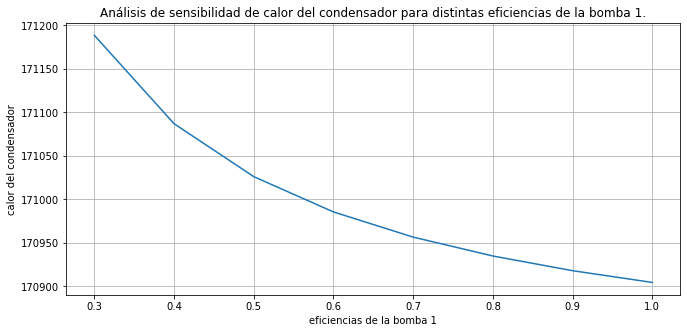

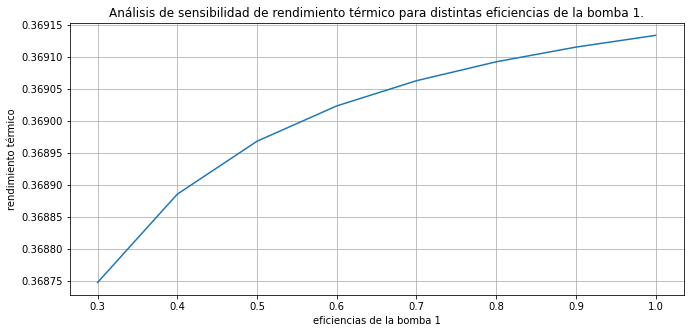

In [35]:
#Variando la eficiencia de la bomba 1 y ceteris paribus
eta_T2 = 0.85
eta_P1 = [i for i in np.arange(0.3, 1.1, 0.1)] #range() no funciona con float
flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento = redefinir()
for eta in eta_P1:
    ciclo10 = RankineCycleRegenerative(p1, t1, p2, p3, x4, x6, w_cycle, eta_T1, eta_T2, eta, eta_P2)
    añadir(flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento, ciclo10)

#Potencias y calores en kW, flujos en kg/s
graficar_todo(flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento, eta_P1, 'eficiencias de la bomba 1')

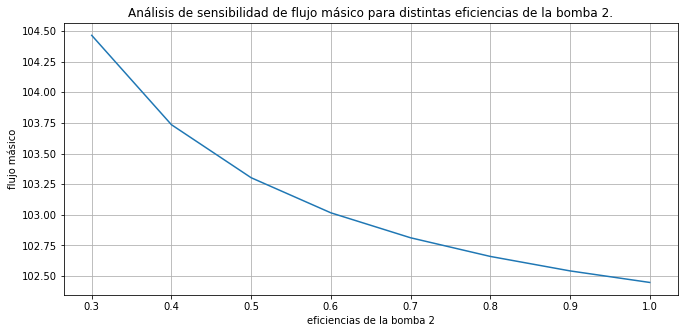

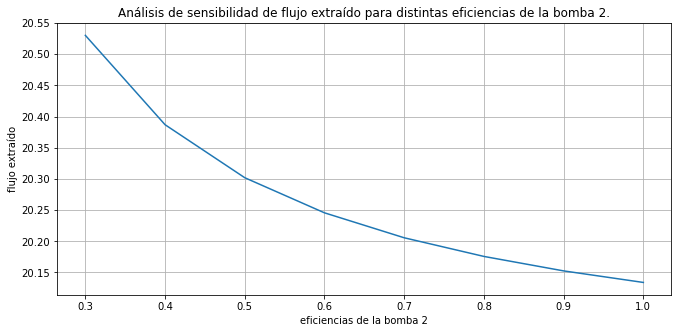

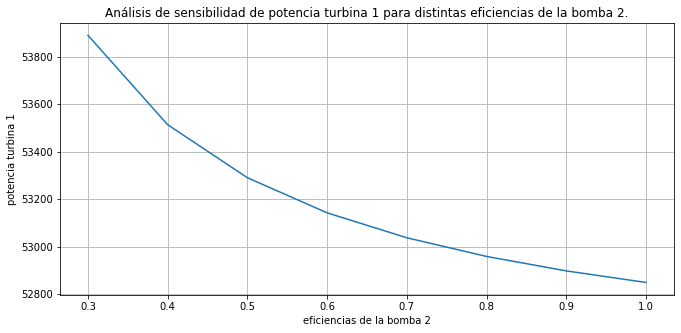

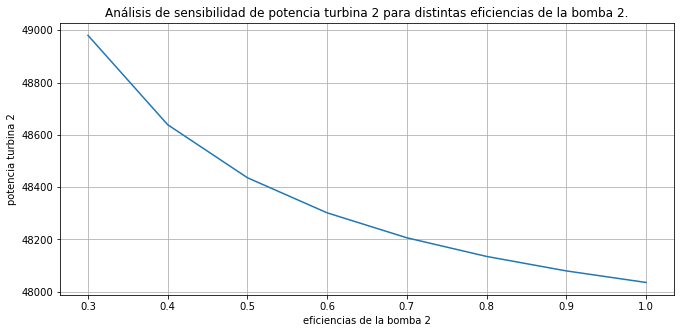

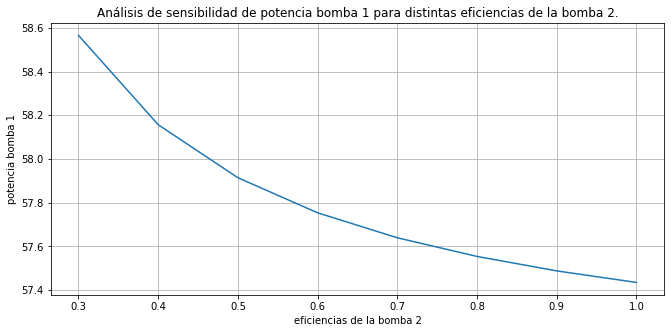

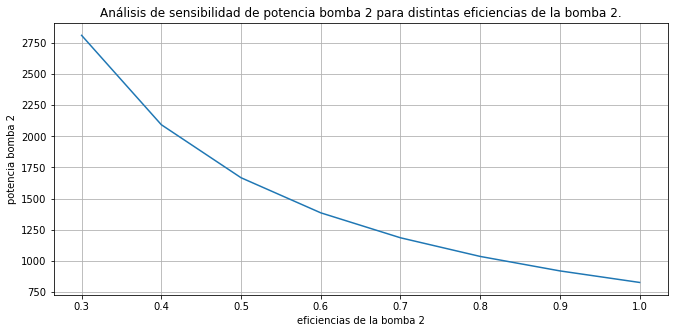

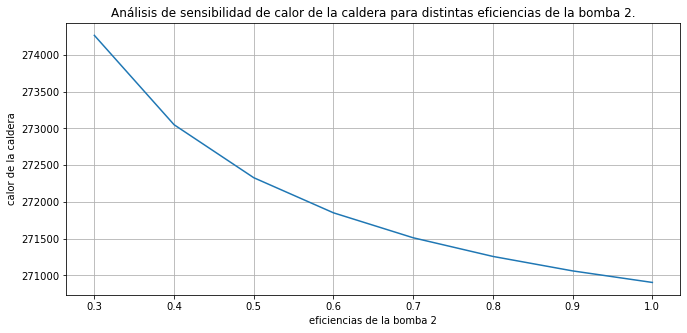

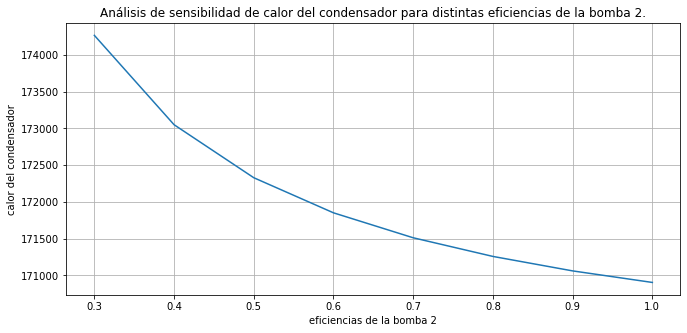

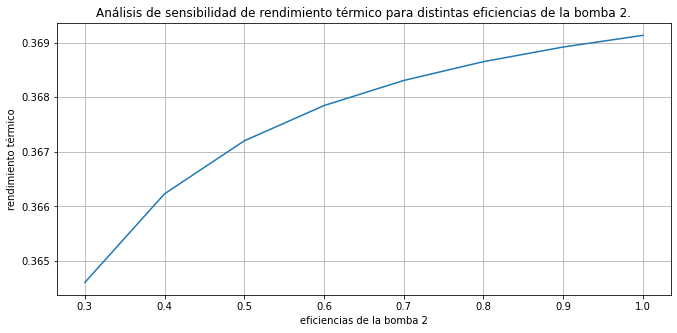

In [36]:
#Variando la eficiencia de la bomba 2 y ceteris paribus
eta_P1 = 1
eta_P2 = [i for i in np.arange(0.3, 1.1, 0.1)] #range() no funciona con float
flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento = redefinir()
for eta in eta_P2:
    ciclo11 = RankineCycleRegenerative(p1, t1, p2, p3, x4, x6, w_cycle, eta_T1, eta_T2, eta_P1, eta)
    añadir(flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento, ciclo11)

#Potencias y calores en kW, flujos en kg/s
graficar_todo(flujomasa, flujoextr, potTurb1, potTurb2, potBomb1, potBomb2, calorIn, calorOut, rendimiento, eta_P2, 'eficiencias de la bomba 2')

In [37]:
#Podemos extraer muchas conclusiones de este análisis de sensibilidad. En los gráficos
# se puede apreciar que cada variable afecta de manera distinta a los resultados.
# En relación al rendimiento térmico, apreciamos que variar el trabajo neto del ciclo
# no tiene ningún efecto. Además, apreciamos que las variables que más influyen son
# la temperatura antes de la turbina 1 y las eficiencias de las turbinas, mientras que
# la eficiencia de las bombas tiene un efecto menor y las calidades tienen un determinado
# punto máximo. Como conclusión, podemos intentar simular el ciclo con los parámetros
# que permitan llegar al máximo rendimiento térmico a partir de los resultados de las
# gráficas del análisis de sensibilidad:

p1 = 12 #Un 50% más que en el ejercicio anterior
t1 = 520 #40ºC más
p2 = 0.9 #0.2 más
p3 = 0.004 #Un 50% menos
x4 = 0.15
x6 = 0.2 #vapor húmedo
w_cycle = 100*1000 #sin cambios
eta_T1 = eta_T2 = eta_P1 = eta_P2 = 1
ciclo = RankineCycleRegenerative(p1, t1, p2, p3, x4, x6, w_cycle, eta_T1, eta_T2, eta_P1, eta_P2)
df = ciclo.hacer_df()
df

Apartado A)



,Presión [MPa],Temperatura [ºC],Entalpía [kJ/kg],Entropía [kJ/kgK],Calidad
Estado 1,12.000,520.000000,3403.374257,6.558396,1.000000
Estado 2 reversible,0.900,175.357822,2744.852333,6.558396,0.986118
Estado 2 irreversible,0.900,175.357822,2744.852333,6.558396,0.986118
Estado 3 reversible,0.004,28.961504,1975.139491,6.558396,0.762131
Estado 3 irreversible,0.004,28.961504,1975.139491,6.558396,0.762131
Estado 4,0.004,28.961504,486.249418,1.630104,0.150000
Estado 5 reversible,0.900,129.630020,545.236723,1.630104,0.000000
Estado 5 irreversible,0.900,129.630020,545.236723,1.630104,0.000000
Estado 6,0.900,175.357822,1148.787217,2.999772,0.200000
Estado 7 reversible,12.000,274.607721,1206.421315,2.999772,0.000000


Apartado B)
 El rendimiento térmico es: eta = 0.508.
 El back work ratio es: bwr = 0.083.
Apartado C)
 El flujo de masa de vapor total es: m_dot = 89.558 kg/s,
 El flujo de masa extraído tras la primera etapa de la turbina es: m_extr = 24.574 kg/s
 y el flujo que pasa por la segunda etapa de la turbina es: m_rest = 64.984 kg/s.
El calor introducido por la caldera es: Qin = 196754.15 kW,
 el extraído por el condensador es: Qout = 96754.15 kW.
El trabajo de la primera etapa de turbina es: Wt1 = 58975.74 kW,
 el trabajo de la segunda etapa es: Wt2 = 50019.08 kW
 y el trabajo de las bombas es: Wp = 8994.82 kW.
Apartado D)



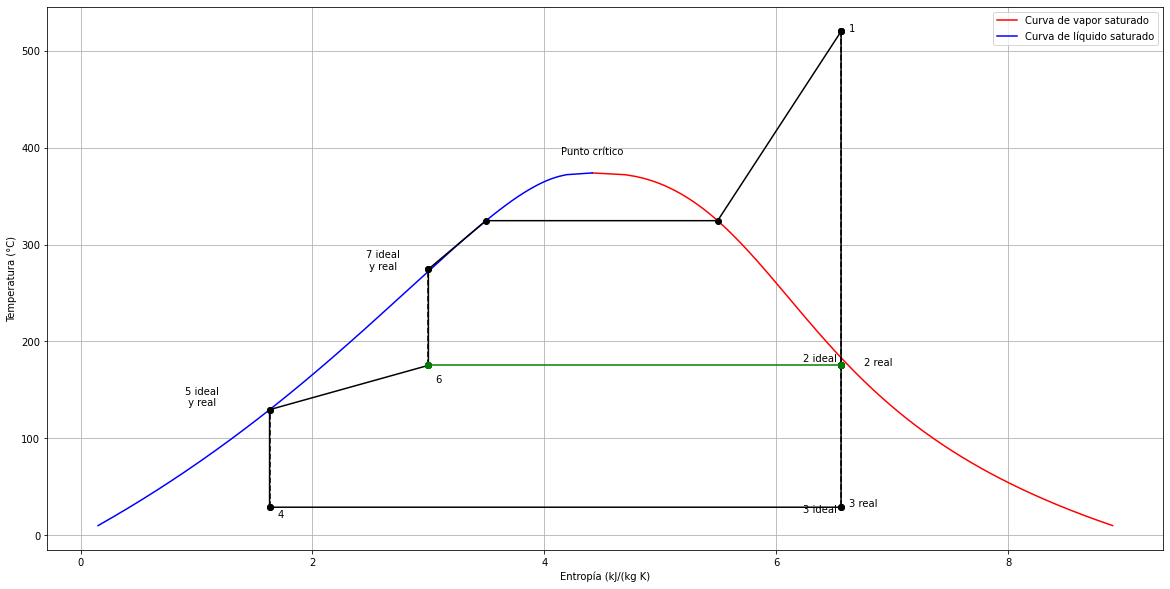

In [38]:
ciclo.mostrar_resultados()
ciclo.pintar_ciclo()

In [39]:
#De esta manera, alcanzamos un rendimiento térmico por encima del 50%. Sin embargo, son condiciones irrealistas,
# ya que se asume que todas las turbinas y bombas trabajan reversiblemente, además de que las bombas
# trabajarían con vapor húmedo y no con líquido en estas condiciones.